# Libs

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import metrics
import pandas as pd
import numpy as np
import gc
import optuna
from optuna.samplers import TPESampler
from scipy import optimize
from scipy import special

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
train_full = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_train_ver2.pkl')

In [ ]:
temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

# Funcs

In [ ]:
from scipy import special

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)

    ll = np.empty_like(p)
    pos = y == 1
    ll[pos] = np.log(p[pos])
    ll[~pos] = np.log(1 - p[~pos])

    is_higher_better = False
    return 'logloss', -ll.mean(), is_higher_better

def logloss_init_score(y):
    p = y.mean()
    p = np.clip(p, 1e-15, 1 - 1e-15)  # never hurts
    log_odds = np.log(p / (1 - p))
    return log_odds

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better
    
def check_gradient(func, grad, values, eps=1e-8):
    approx = (func(values + eps) - func(values - eps)) / (2 * eps)
    return np.linalg.norm(approx - grad(values))

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [ ]:
def cal_gini(model, data, features):
    pred = model.predict(data[features])
    auc = roc_auc_score(data['TARGET'], pred)
    gini = 2*auc - 1
    return gini 

# Base model

In [ ]:
fl = FocalLoss(alpha=None, gamma=0)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model = lgb.train(
    params={'learning_rate': 0.018437, 
          'num_leaves': 58,
          'max_bin': 300,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':7, 
          'reg_alpha':3.564, 
          'reg_lambda':4.930, 
          'min_split_gain':0.143, 
          'min_child_weight':6, 'verbose': -1},
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=100,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

Training until validation scores don't improve for 100 rounds
[100]	fit's focal_loss: 0.240949	val's focal_loss: 0.245077
[200]	fit's focal_loss: 0.229691	val's focal_loss: 0.238873
[300]	fit's focal_loss: 0.222784	val's focal_loss: 0.23641
[400]	fit's focal_loss: 0.217397	val's focal_loss: 0.235039
[500]	fit's focal_loss: 0.212968	val's focal_loss: 0.234316
[600]	fit's focal_loss: 0.208845	val's focal_loss: 0.233776
[700]	fit's focal_loss: 0.204972	val's focal_loss: 0.233383
[800]	fit's focal_loss: 0.201493	val's focal_loss: 0.233103
[900]	fit's focal_loss: 0.197993	val's focal_loss: 0.232918
[1000]	fit's focal_loss: 0.194648	val's focal_loss: 0.232728
[1100]	fit's focal_loss: 0.191463	val's focal_loss: 0.232661
[1200]	fit's focal_loss: 0.188388	val's focal_loss: 0.232612
[1300]	fit's focal_loss: 0.185448	val's focal_loss: 0.232555
Early stopping, best iteration is:
[1294]	fit's focal_loss: 0.185608	val's focal_loss: 0.232546


In [ ]:
y_pred_test = special.expit(fl.init_score(train['TARGET']) + model.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
y_pred_valid = special.expit(fl.init_score(train['TARGET']) + model.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred_test):.5f}")
print(f"Valid's ROC AUC: {metrics.roc_auc_score(valid['TARGET'], y_pred_valid):.5f}")


Test's ROC AUC: 0.79479
Valid's ROC AUC: 0.79725


# Optuna

In [ ]:
def objective(trial):
    params_lgb = {
        "objective": "binary",
        "boost_from_average": True,
        "verbose": -1,
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int('max_bin', 250, 350),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1),
        "num_leaves": trial.suggest_int("num_leaves", 5, 50),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 5),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 5),
        "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 5000),
        'feature_fraction' : trial.suggest_loguniform('feature_fraction', 0.01, 1),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 5)
    }
    params_focal = {'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
                   'gamma': trial.suggest_loguniform('gamma', 1e-3, 5)}
    
    fl = FocalLoss(alpha=params_focal['alpha'], gamma=params_focal['gamma'])

    fit = lgb.Dataset(
        train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
        init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
    )

    val = lgb.Dataset(
        valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
        init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
        reference=fit
    )
    
    model_tune = lgb.train(params = params_lgb, train_set = fit, num_boost_round=1000,
                           valid_sets=(fit, val), valid_names = ('fit', 'val'),
                           early_stopping_rounds=50, verbose_eval = 100, 
                           fobj=fl.lgb_obj, feval=fl.lgb_eval)
    
    pred_valid = special.expit(fl.init_score(train['TARGET']) + model_tune.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
    gini_ = 2 * metrics.roc_auc_score(valid['TARGET'], pred_valid) - 1
    print('GINI ', gini_)
    del model_tune, fit, val
    gc.collect()
    return gini_

In [ ]:
study_tuner1 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                            direction="maximize", sampler = TPESampler())
study_tuner1.optimize(objective, n_trials=100)
print(study_tuner1.best_trial)

[I 2023-05-17 14:51:48,126] A new study created in memory with name: no-name-89e28403-ba7c-445b-a5de-1172bfcc89ad


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.246095	val's focal_loss: 0.243067


[I 2023-05-17 14:52:15,421] Trial 0 finished with value: 0.0 and parameters: {'max_bin': 176, 'max_depth': 16, 'learning_rate': 0.1793787497462533, 'num_leaves': 18, 'lambda_l2': 0.00011738898885954292, 'lambda_l1': 0.038500575269646564, 'min_gain_to_split': 3.749899700997014e-08, 'min_data_in_leaf': 625, 'feature_fraction': 0.7832428328021604, 'min_sum_hessian_in_leaf': 1.2029175155737903e-05, 'alpha': 1.3180485513445241, 'gamma': 0.07951423474934162}. Best is trial 0 with value: 0.0.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0854274	val's focal_loss: 0.0857234
[200]	fit's focal_loss: 0.0829316	val's focal_loss: 0.0841011
[300]	fit's focal_loss: 0.0816002	val's focal_loss: 0.0835208
[400]	fit's focal_loss: 0.0805762	val's focal_loss: 0.0832135
[500]	fit's focal_loss: 0.0797037	val's focal_loss: 0.083013
[600]	fit's focal_loss: 0.078929	val's focal_loss: 0.0829286
[700]	fit's focal_loss: 0.0782211	val's focal_loss: 0.0828782
[800]	fit's focal_loss: 0.0775546	val's focal_loss: 0.0828917
Early stopping, best iteration is:
[759]	fit's focal_loss: 0.07782	val's focal_loss: 0.0828676


[I 2023-05-17 14:56:25,723] Trial 1 finished with value: 0.5905929534544077 and parameters: {'max_bin': 175, 'max_depth': 15, 'learning_rate': 0.06240733104775726, 'num_leaves': 14, 'lambda_l2': 4.197793552410169, 'lambda_l1': 3.1062281607771655e-07, 'min_gain_to_split': 0.003697441568004437, 'min_data_in_leaf': 2582, 'feature_fraction': 0.0502249458755898, 'min_sum_hessian_in_leaf': 0.01904151105845987, 'alpha': 0.28910552454346305, 'gamma': 0.06073268900703201}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5905929534544077
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.000522666	val's focal_loss: 0.000518764
[200]	fit's focal_loss: 0.000451136	val's focal_loss: 0.000446524
[300]	fit's focal_loss: 0.000450129	val's focal_loss: 0.000445455
Early stopping, best iteration is:
[269]	fit's focal_loss: 0.000450129	val's focal_loss: 0.000445455


[I 2023-05-17 14:58:14,978] Trial 2 finished with value: 0.47877096553187526 and parameters: {'max_bin': 211, 'max_depth': 14, 'learning_rate': 0.057990583911588525, 'num_leaves': 36, 'lambda_l2': 0.485631388255163, 'lambda_l1': 0.1072017838096523, 'min_gain_to_split': 0.28595227979963916, 'min_data_in_leaf': 2722, 'feature_fraction': 0.15939146031588086, 'min_sum_hessian_in_leaf': 0.0009907614820093343, 'alpha': 0.0015834593643502064, 'gamma': 1.8365762467242797}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.47877096553187526
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0393865	val's focal_loss: 0.0428881
Early stopping, best iteration is:
[92]	fit's focal_loss: 0.0396957	val's focal_loss: 0.0428749


[I 2023-05-17 14:59:27,380] Trial 3 finished with value: 0.5757999708125714 and parameters: {'max_bin': 162, 'max_depth': 17, 'learning_rate': 0.14357573143217964, 'num_leaves': 41, 'lambda_l2': 0.00017690484566113682, 'lambda_l1': 0.09188628762581434, 'min_gain_to_split': 9.124265850609524e-05, 'min_data_in_leaf': 997, 'feature_fraction': 0.6258404279832833, 'min_sum_hessian_in_leaf': 2.8282425983378262e-05, 'alpha': 0.10808543508748776, 'gamma': 0.0027081703790511314}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5757999708125714
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0213105	val's focal_loss: 0.0212287
[200]	fit's focal_loss: 0.0205598	val's focal_loss: 0.0206007
[300]	fit's focal_loss: 0.0201726	val's focal_loss: 0.0203091
[400]	fit's focal_loss: 0.0199627	val's focal_loss: 0.0201994
[500]	fit's focal_loss: 0.0197831	val's focal_loss: 0.0201112
[600]	fit's focal_loss: 0.0196231	val's focal_loss: 0.0200387
[700]	fit's focal_loss: 0.0195007	val's focal_loss: 0.0200012
[800]	fit's focal_loss: 0.0193985	val's focal_loss: 0.0199763
[900]	fit's focal_loss: 0.0193116	val's focal_loss: 0.0199632
[1000]	fit's focal_loss: 0.0192196	val's focal_loss: 0.0199535
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0192196	val's focal_loss: 0.0199535


[I 2023-05-17 15:03:50,284] Trial 4 finished with value: 0.5805120195203615 and parameters: {'max_bin': 239, 'max_depth': 7, 'learning_rate': 0.03773470825264503, 'num_leaves': 41, 'lambda_l2': 0.0001273834809564533, 'lambda_l1': 0.024925235577515536, 'min_gain_to_split': 3.859500901223274e-07, 'min_data_in_leaf': 4871, 'feature_fraction': 0.02725558880995986, 'min_sum_hessian_in_leaf': 4.862783132389145e-08, 'alpha': 0.06005650514874118, 'gamma': 0.4142869226454164}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5805120195203615
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00653875	val's focal_loss: 0.00658433
Early stopping, best iteration is:
[148]	fit's focal_loss: 0.00653029	val's focal_loss: 0.00657685


[I 2023-05-17 15:04:49,205] Trial 5 finished with value: 0.5704335029500294 and parameters: {'max_bin': 150, 'max_depth': 7, 'learning_rate': 0.24646318063414185, 'num_leaves': 29, 'lambda_l2': 0.010198353207020242, 'lambda_l1': 2.577452893988644e-07, 'min_gain_to_split': 0.23263542668763917, 'min_data_in_leaf': 1848, 'feature_fraction': 0.05271240749268002, 'min_sum_hessian_in_leaf': 0.005155284621518847, 'alpha': 0.026870600763551897, 'gamma': 1.2229165993647213}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5704335029500294
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00123876	val's focal_loss: 0.00123116
[200]	fit's focal_loss: 0.00115887	val's focal_loss: 0.00116096
[300]	fit's focal_loss: 0.00113819	val's focal_loss: 0.00114994
[400]	fit's focal_loss: 0.00112575	val's focal_loss: 0.00114628
[500]	fit's focal_loss: 0.00111575	val's focal_loss: 0.00114434
[600]	fit's focal_loss: 0.00110654	val's focal_loss: 0.0011432
[700]	fit's focal_loss: 0.00109795	val's focal_loss: 0.00114276
Early stopping, best iteration is:
[700]	fit's focal_loss: 0.00109795	val's focal_loss: 0.00114276


[I 2023-05-17 15:08:28,227] Trial 6 finished with value: 0.5865494301637053 and parameters: {'max_bin': 247, 'max_depth': 7, 'learning_rate': 0.04558135971450416, 'num_leaves': 36, 'lambda_l2': 0.0027845257086198854, 'lambda_l1': 9.129920695961353e-08, 'min_gain_to_split': 0.0001880437199115671, 'min_data_in_leaf': 1622, 'feature_fraction': 0.055319580760092045, 'min_sum_hessian_in_leaf': 0.10440768910879404, 'alpha': 0.0027081772188056034, 'gamma': 0.7507834262644068}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5865494301637053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 3.3943	val's focal_loss: 3.39992


[I 2023-05-17 15:09:01,246] Trial 7 finished with value: 0.2937708267572914 and parameters: {'max_bin': 227, 'max_depth': 9, 'learning_rate': 0.6993667122054222, 'num_leaves': 6, 'lambda_l2': 0.00031505720469797124, 'lambda_l1': 0.08582116684678812, 'min_gain_to_split': 0.00019883156570901144, 'min_data_in_leaf': 1440, 'feature_fraction': 0.14922197697460202, 'min_sum_hessian_in_leaf': 0.00027111787731380507, 'alpha': 0.26045620161736693, 'gamma': 3.3693245888326055}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.2937708267572914
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0329095	val's focal_loss: 0.035526
Early stopping, best iteration is:
[97]	fit's focal_loss: 0.032996	val's focal_loss: 0.0355166


[I 2023-05-17 15:09:56,692] Trial 8 finished with value: 0.5673952050446702 and parameters: {'max_bin': 226, 'max_depth': 15, 'learning_rate': 0.23563696595024122, 'num_leaves': 48, 'lambda_l2': 7.919586348559966e-08, 'lambda_l1': 0.15928365069884082, 'min_gain_to_split': 1.218363062148469e-06, 'min_data_in_leaf': 2264, 'feature_fraction': 0.029775450210393857, 'min_sum_hessian_in_leaf': 3.41728239554106e-05, 'alpha': 0.11133130876471554, 'gamma': 0.2954257988912421}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5673952050446702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0774029	val's focal_loss: 0.0774759


[I 2023-05-17 15:10:23,756] Trial 9 finished with value: 0.0 and parameters: {'max_bin': 154, 'max_depth': 15, 'learning_rate': 0.02498175192467852, 'num_leaves': 38, 'lambda_l2': 0.15101267524346337, 'lambda_l1': 3.579806115573514e-07, 'min_gain_to_split': 0.001668650098086741, 'min_data_in_leaf': 1325, 'feature_fraction': 0.043026626031778474, 'min_sum_hessian_in_leaf': 0.0001226762344855272, 'alpha': 0.0015639364800481698, 'gamma': 0.0015667900881334664}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.641894	val's focal_loss: 0.63154


[I 2023-05-17 15:10:43,558] Trial 10 finished with value: 0.0 and parameters: {'max_bin': 187, 'max_depth': 20, 'learning_rate': 0.020389780014063046, 'num_leaves': 14, 'lambda_l2': 3.3539396148884486, 'lambda_l1': 2.3856989480516233e-05, 'min_gain_to_split': 0.012713363874183257, 'min_data_in_leaf': 3453, 'feature_fraction': 0.014330797213189762, 'min_sum_hessian_in_leaf': 4.410502248233492, 'alpha': 4.402945172628403, 'gamma': 0.01773194743083187}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0678657	val's focal_loss: 0.0679029


[I 2023-05-17 15:11:06,338] Trial 11 finished with value: 0.0 and parameters: {'max_bin': 250, 'max_depth': 11, 'learning_rate': 0.013597447772000594, 'num_leaves': 24, 'lambda_l2': 0.021164702031649187, 'lambda_l1': 1.0549023147151687e-08, 'min_gain_to_split': 4.017537035480996, 'min_data_in_leaf': 3207, 'feature_fraction': 0.09203275141811514, 'min_sum_hessian_in_leaf': 0.09479849735735142, 'alpha': 0.012138126639762704, 'gamma': 0.06263714187979753}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0250317	val's focal_loss: 0.0250384


[I 2023-05-17 15:11:26,299] Trial 12 finished with value: 0.0 and parameters: {'max_bin': 202, 'max_depth': 11, 'learning_rate': 0.06935029042471888, 'num_leaves': 5, 'lambda_l2': 2.114296216968227, 'lambda_l1': 1.6597637944112335e-05, 'min_gain_to_split': 3.07652973158292e-05, 'min_data_in_leaf': 4090, 'feature_fraction': 0.010005028682457761, 'min_sum_hessian_in_leaf': 0.07441669474165337, 'alpha': 0.007576631126190677, 'gamma': 0.47065810473930525}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.130061	val's focal_loss: 0.130473
[200]	fit's focal_loss: 0.123988	val's focal_loss: 0.1252
[300]	fit's focal_loss: 0.120652	val's focal_loss: 0.122462
[400]	fit's focal_loss: 0.118578	val's focal_loss: 0.120919
[500]	fit's focal_loss: 0.117023	val's focal_loss: 0.119894
[600]	fit's focal_loss: 0.115767	val's focal_loss: 0.119134
[700]	fit's focal_loss: 0.114619	val's focal_loss: 0.118496
[800]	fit's focal_loss: 0.113594	val's focal_loss: 0.117969
[900]	fit's focal_loss: 0.1127	val's focal_loss: 0.117575
[1000]	fit's focal_loss: 0.111889	val's focal_loss: 0.11727
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.111889	val's focal_loss: 0.11727


[I 2023-05-17 15:16:48,865] Trial 13 finished with value: 0.5790985581072063 and parameters: {'max_bin': 181, 'max_depth': 19, 'learning_rate': 0.010095401769199958, 'num_leaves': 30, 'lambda_l2': 0.030895476150415276, 'lambda_l1': 2.7175547831682115e-08, 'min_gain_to_split': 0.0035114854379222657, 'min_data_in_leaf': 2328, 'feature_fraction': 0.07906674827592103, 'min_sum_hessian_in_leaf': 2.808352631524838, 'alpha': 0.6438209287763366, 'gamma': 0.09272786841202203}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5790985581072063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0751268	val's focal_loss: 0.0751895


[I 2023-05-17 15:17:08,884] Trial 14 finished with value: 0.0 and parameters: {'max_bin': 195, 'max_depth': 5, 'learning_rate': 0.042398173186907515, 'num_leaves': 18, 'lambda_l2': 4.1569782178542285, 'lambda_l1': 1.3519864976086556e-06, 'min_gain_to_split': 1.1307281778882739e-05, 'min_data_in_leaf': 214, 'feature_fraction': 0.023559248055880114, 'min_sum_hessian_in_leaf': 0.030002985227183736, 'alpha': 0.004770517844071342, 'gamma': 0.015680665733608854}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00130815	val's focal_loss: 0.00136271
[200]	fit's focal_loss: 0.00125291	val's focal_loss: 0.00135325
[300]	fit's focal_loss: 0.00120723	val's focal_loss: 0.00135189
Early stopping, best iteration is:
[275]	fit's focal_loss: 0.00121783	val's focal_loss: 0.00135178


[I 2023-05-17 15:18:11,234] Trial 15 finished with value: 0.5823779457641072 and parameters: {'max_bin': 171, 'max_depth': 12, 'learning_rate': 0.08649072442365137, 'num_leaves': 49, 'lambda_l2': 0.006327978306505674, 'lambda_l1': 0.00037950405357227684, 'min_gain_to_split': 0.0004936612757273404, 'min_data_in_leaf': 2979, 'feature_fraction': 0.05696770828337946, 'min_sum_hessian_in_leaf': 0.5725178112226637, 'alpha': 0.031547482834081805, 'gamma': 4.364461136786856}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5823779457641072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0163917	val's focal_loss: 0.0164056


[I 2023-05-17 15:18:43,097] Trial 16 finished with value: 0.0 and parameters: {'max_bin': 210, 'max_depth': 9, 'learning_rate': 0.102947632963331, 'num_leaves': 11, 'lambda_l2': 0.27143575930331376, 'lambda_l1': 7.456925010224619e-08, 'min_gain_to_split': 0.014141437160130405, 'min_data_in_leaf': 2010, 'feature_fraction': 0.19780037751032775, 'min_sum_hessian_in_leaf': 0.008635188490041024, 'alpha': 0.0010408989951174255, 'gamma': 0.622265563126996}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0567327	val's focal_loss: 0.0566847
[200]	fit's focal_loss: 0.0546968	val's focal_loss: 0.0550732
[300]	fit's focal_loss: 0.053513	val's focal_loss: 0.054266
[400]	fit's focal_loss: 0.052717	val's focal_loss: 0.0538146
[500]	fit's focal_loss: 0.0521524	val's focal_loss: 0.0536085
[600]	fit's focal_loss: 0.0516657	val's focal_loss: 0.0534756
[700]	fit's focal_loss: 0.0512107	val's focal_loss: 0.0533529
[800]	fit's focal_loss: 0.0508045	val's focal_loss: 0.0532988
[900]	fit's focal_loss: 0.0504157	val's focal_loss: 0.0532365
[1000]	fit's focal_loss: 0.0500283	val's focal_loss: 0.0531825
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0500283	val's focal_loss: 0.0531825
GINI  0.5840135957310348


[I 2023-05-17 15:22:42,930] Trial 17 finished with value: 0.5840135957310348 and parameters: {'max_bin': 165, 'max_depth': 18, 'learning_rate': 0.0331296572647972, 'num_leaves': 24, 'lambda_l2': 0.001837044040038133, 'lambda_l1': 1.9993552756449384e-06, 'min_gain_to_split': 1.8884554066182353e-05, 'min_data_in_leaf': 3834, 'feature_fraction': 0.03999218133401455, 'min_sum_hessian_in_leaf': 0.135419912976524, 'alpha': 0.17521269182127205, 'gamma': 0.19725546460255586}. Best is trial 1 with value: 0.5905929534544077.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00125417	val's focal_loss: 0.00124786
[200]	fit's focal_loss: 0.00121643	val's focal_loss: 0.00122027
[300]	fit's focal_loss: 0.00119376	val's focal_loss: 0.00120657
[400]	fit's focal_loss: 0.00118064	val's focal_loss: 0.00120253
[500]	fit's focal_loss: 0.00116709	val's focal_loss: 0.00119776
[600]	fit's focal_loss: 0.0011567	val's focal_loss: 0.00119613
[700]	fit's focal_loss: 0.00114692	val's focal_loss: 0.00119464
[800]	fit's focal_loss: 0.00113784	val's focal_loss: 0.00119398
[900]	fit's focal_loss: 0.00112941	val's focal_loss: 0.00119365
Early stopping, best iteration is:
[881]	fit's focal_loss: 0.00113082	val's focal_loss: 0.00119357


[I 2023-05-17 15:26:45,971] Trial 18 finished with value: 0.571285767905428 and parameters: {'max_bin': 190, 'max_depth': 13, 'learning_rate': 0.04679156693657447, 'num_leaves': 32, 'lambda_l2': 1.1541917611957295e-05, 'lambda_l1': 2.086171871187555e-08, 'min_gain_to_split': 0.0007563664542991487, 'min_data_in_leaf': 1580, 'feature_fraction': 0.01976560849477193, 'min_sum_hessian_in_leaf': 0.34447547461501854, 'alpha': 0.0037158451097250946, 'gamma': 1.2435195005285145}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.571285767905428
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0139448	val's focal_loss: 0.0139327
[200]	fit's focal_loss: 0.0135341	val's focal_loss: 0.0136487
[300]	fit's focal_loss: 0.0133709	val's focal_loss: 0.0135859
[400]	fit's focal_loss: 0.0132497	val's focal_loss: 0.0135596
[500]	fit's focal_loss: 0.0131518	val's focal_loss: 0.0135486
[600]	fit's focal_loss: 0.0130595	val's focal_loss: 0.0135478
Early stopping, best iteration is:
[553]	fit's focal_loss: 0.0131018	val's focal_loss: 0.0135468


[I 2023-05-17 15:29:42,986] Trial 19 finished with value: 0.5865050222969472 and parameters: {'max_bin': 223, 'max_depth': 5, 'learning_rate': 0.06495759482365708, 'num_leaves': 24, 'lambda_l2': 0.30949545589222505, 'lambda_l1': 1.0057922058497421e-07, 'min_gain_to_split': 0.0001162268706457006, 'min_data_in_leaf': 2542, 'feature_fraction': 0.06834301735717256, 'min_sum_hessian_in_leaf': 0.005876978462684619, 'alpha': 0.03112699063270625, 'gamma': 0.1776178664374785}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5865050222969472
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00617969	val's focal_loss: 0.00614587
[200]	fit's focal_loss: 0.00561086	val's focal_loss: 0.00559231
[300]	fit's focal_loss: 0.00549569	val's focal_loss: 0.00549938
[400]	fit's focal_loss: 0.00543631	val's focal_loss: 0.00546396
[500]	fit's focal_loss: 0.00539453	val's focal_loss: 0.00544604
[600]	fit's focal_loss: 0.00536164	val's focal_loss: 0.00543668
[700]	fit's focal_loss: 0.00533309	val's focal_loss: 0.00543162
[800]	fit's focal_loss: 0.00530742	val's focal_loss: 0.00542785
[900]	fit's focal_loss: 0.00528339	val's focal_loss: 0.00542578
[1000]	fit's focal_loss: 0.00526145	val's focal_loss: 0.00542463
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00526145	val's focal_loss: 0.00542463


[I 2023-05-17 15:35:17,490] Trial 20 finished with value: 0.5876780903184782 and parameters: {'max_bin': 245, 'max_depth': 9, 'learning_rate': 0.02173308360869416, 'num_leaves': 19, 'lambda_l2': 0.05744584898502646, 'lambda_l1': 1.5200982793556031e-06, 'min_gain_to_split': 4.297565216921796e-06, 'min_data_in_leaf': 1017, 'feature_fraction': 0.12588678734691464, 'min_sum_hessian_in_leaf': 0.5526597956465913, 'alpha': 0.01668755723140838, 'gamma': 0.8050803232304089}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5876780903184782
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00719559	val's focal_loss: 0.0071582
[200]	fit's focal_loss: 0.00609628	val's focal_loss: 0.00606842
[300]	fit's focal_loss: 0.00593234	val's focal_loss: 0.00592438
[400]	fit's focal_loss: 0.00586085	val's focal_loss: 0.00587514
[500]	fit's focal_loss: 0.0058147	val's focal_loss: 0.00585181
[600]	fit's focal_loss: 0.00577951	val's focal_loss: 0.00584005
[700]	fit's focal_loss: 0.00574915	val's focal_loss: 0.00583344
[800]	fit's focal_loss: 0.00572276	val's focal_loss: 0.0058296
[900]	fit's focal_loss: 0.00569885	val's focal_loss: 0.00582721
[1000]	fit's focal_loss: 0.00567583	val's focal_loss: 0.005825
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00567583	val's focal_loss: 0.005825


[I 2023-05-17 15:40:38,650] Trial 21 finished with value: 0.5854469034018477 and parameters: {'max_bin': 247, 'max_depth': 9, 'learning_rate': 0.02130363768391719, 'num_leaves': 18, 'lambda_l2': 0.060611394979205625, 'lambda_l1': 1.334578185264264e-06, 'min_gain_to_split': 3.6540478694317915e-06, 'min_data_in_leaf': 886, 'feature_fraction': 0.11308144150120773, 'min_sum_hessian_in_leaf': 0.6866373871671249, 'alpha': 0.015698223507679916, 'gamma': 0.5852468768767206}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5854469034018477
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.000863948	val's focal_loss: 0.000857912
[200]	fit's focal_loss: 0.000842884	val's focal_loss: 0.000839529
[300]	fit's focal_loss: 0.000835024	val's focal_loss: 0.000834477
[400]	fit's focal_loss: 0.000830139	val's focal_loss: 0.000832211
[500]	fit's focal_loss: 0.000826527	val's focal_loss: 0.000831039
[600]	fit's focal_loss: 0.0008236	val's focal_loss: 0.000830337
[700]	fit's focal_loss: 0.000821035	val's focal_loss: 0.000829951
[800]	fit's focal_loss: 0.000818661	val's focal_loss: 0.000829609
[900]	fit's focal_loss: 0.000816464	val's focal_loss: 0.000829392
[1000]	fit's focal_loss: 0.000814376	val's focal_loss: 0.000829256
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.000814376	val's focal_loss: 0.000829256


[I 2023-05-17 15:46:56,924] Trial 22 finished with value: 0.5866120826603096 and parameters: {'max_bin': 237, 'max_depth': 7, 'learning_rate': 0.03498394855314043, 'num_leaves': 10, 'lambda_l2': 0.668927009276023, 'lambda_l1': 1.2365389161976898e-07, 'min_gain_to_split': 4.93536950400968e-06, 'min_data_in_leaf': 207, 'feature_fraction': 0.23013176438374527, 'min_sum_hessian_in_leaf': 0.034990447045394404, 'alpha': 0.003325464061329265, 'gamma': 1.8273240334270364}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5866120826603096
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00106495	val's focal_loss: 0.00105948
[200]	fit's focal_loss: 0.00104702	val's focal_loss: 0.00104584
[300]	fit's focal_loss: 0.00103737	val's focal_loss: 0.00104035
[400]	fit's focal_loss: 0.00103073	val's focal_loss: 0.0010374
[500]	fit's focal_loss: 0.00102558	val's focal_loss: 0.00103589
[600]	fit's focal_loss: 0.00102133	val's focal_loss: 0.00103505
[700]	fit's focal_loss: 0.00101752	val's focal_loss: 0.00103432
[800]	fit's focal_loss: 0.00101393	val's focal_loss: 0.00103376
[900]	fit's focal_loss: 0.00101065	val's focal_loss: 0.00103342
[1000]	fit's focal_loss: 0.00100754	val's focal_loss: 0.0010333
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00100754	val's focal_loss: 0.0010333


[I 2023-05-17 15:54:00,235] Trial 23 finished with value: 0.5857809870464123 and parameters: {'max_bin': 236, 'max_depth': 10, 'learning_rate': 0.028553772356830008, 'num_leaves': 11, 'lambda_l2': 0.8902832467909787, 'lambda_l1': 7.193931553670903e-06, 'min_gain_to_split': 4.5515193422620213e-07, 'min_data_in_leaf': 256, 'feature_fraction': 0.2901103379623677, 'min_sum_hessian_in_leaf': 0.01725209116113967, 'alpha': 0.0061161780988861665, 'gamma': 2.4896868385394972}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5857809870464123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.00197383	val's focal_loss: 0.00195153


[I 2023-05-17 15:54:22,305] Trial 24 finished with value: 0.0 and parameters: {'max_bin': 236, 'max_depth': 8, 'learning_rate': 0.015283293010313313, 'num_leaves': 10, 'lambda_l2': 0.8910934313910448, 'lambda_l1': 3.430726374839456e-07, 'min_gain_to_split': 4.839607816878348e-06, 'min_data_in_leaf': 713, 'feature_fraction': 0.2829260881825896, 'min_sum_hessian_in_leaf': 1.3336192286425173, 'alpha': 0.014781071921726225, 'gamma': 4.99049868243655}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00187608	val's focal_loss: 0.00186549
[200]	fit's focal_loss: 0.00181216	val's focal_loss: 0.00180635
[300]	fit's focal_loss: 0.0017878	val's focal_loss: 0.0017866
[400]	fit's focal_loss: 0.00177322	val's focal_loss: 0.00177646
[500]	fit's focal_loss: 0.00176307	val's focal_loss: 0.00177079
[600]	fit's focal_loss: 0.0017552	val's focal_loss: 0.00176741
[700]	fit's focal_loss: 0.00174858	val's focal_loss: 0.00176514
[800]	fit's focal_loss: 0.00174256	val's focal_loss: 0.00176334
[900]	fit's focal_loss: 0.00173698	val's focal_loss: 0.00176207
[1000]	fit's focal_loss: 0.00173184	val's focal_loss: 0.00176111
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00173184	val's focal_loss: 0.00176111


[I 2023-05-17 15:59:33,598] Trial 25 finished with value: 0.5872028246745786 and parameters: {'max_bin': 219, 'max_depth': 13, 'learning_rate': 0.028938625903946306, 'num_leaves': 15, 'lambda_l2': 4.976787831440165, 'lambda_l1': 0.00013799674676390124, 'min_gain_to_split': 1.1511551427006213e-08, 'min_data_in_leaf': 1132, 'feature_fraction': 0.10603352871325289, 'min_sum_hessian_in_leaf': 0.38964882387885796, 'alpha': 0.006799449943379998, 'gamma': 1.5254512468061356}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5872028246745786
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0154418	val's focal_loss: 0.0154083
[200]	fit's focal_loss: 0.0149324	val's focal_loss: 0.0149807
[300]	fit's focal_loss: 0.0147035	val's focal_loss: 0.0148379
[400]	fit's focal_loss: 0.0145499	val's focal_loss: 0.0147676
[500]	fit's focal_loss: 0.0144287	val's focal_loss: 0.0147268
[600]	fit's focal_loss: 0.0143245	val's focal_loss: 0.0147003
[700]	fit's focal_loss: 0.0142323	val's focal_loss: 0.0146849
[800]	fit's focal_loss: 0.0141464	val's focal_loss: 0.0146733
[900]	fit's focal_loss: 0.0140649	val's focal_loss: 0.0146655
[1000]	fit's focal_loss: 0.0139887	val's focal_loss: 0.0146588
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0139887	val's focal_loss: 0.0146588


[I 2023-05-17 16:05:04,541] Trial 26 finished with value: 0.5878868789178326 and parameters: {'max_bin': 214, 'max_depth': 13, 'learning_rate': 0.023118885411132016, 'num_leaves': 21, 'lambda_l2': 3.9362282329049605, 'lambda_l1': 8.655693605382498e-05, 'min_gain_to_split': 1.0472897241306764e-08, 'min_data_in_leaf': 1011, 'feature_fraction': 0.12480379283297761, 'min_sum_hessian_in_leaf': 0.5939794370979593, 'alpha': 0.06308282162226478, 'gamma': 1.0111037223067525}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5878868789178326
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0133703	val's focal_loss: 0.0132944
[200]	fit's focal_loss: 0.0128468	val's focal_loss: 0.0128105
[300]	fit's focal_loss: 0.012599	val's focal_loss: 0.0126031
[400]	fit's focal_loss: 0.0124429	val's focal_loss: 0.0124862
[500]	fit's focal_loss: 0.012343	val's focal_loss: 0.0124249
[600]	fit's focal_loss: 0.012264	val's focal_loss: 0.0123839
[700]	fit's focal_loss: 0.0121986	val's focal_loss: 0.0123553
[800]	fit's focal_loss: 0.0121413	val's focal_loss: 0.012334
[900]	fit's focal_loss: 0.0120895	val's focal_loss: 0.0123171
[1000]	fit's focal_loss: 0.0120418	val's focal_loss: 0.0123062
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0120418	val's focal_loss: 0.0123062


[I 2023-05-17 16:10:06,459] Trial 27 finished with value: 0.5855044326790568 and parameters: {'max_bin': 209, 'max_depth': 14, 'learning_rate': 0.017193833844996616, 'num_leaves': 21, 'lambda_l2': 0.0852003909780925, 'lambda_l1': 0.00016460066503547224, 'min_gain_to_split': 6.920092910785388e-08, 'min_data_in_leaf': 4781, 'feature_fraction': 0.0823131749210661, 'min_sum_hessian_in_leaf': 3.8092105527108493, 'alpha': 0.04875122785161664, 'gamma': 0.9509290872481063}. Best is trial 1 with value: 0.5905929534544077.


GINI  0.5855044326790568
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0772689	val's focal_loss: 0.0773553
[200]	fit's focal_loss: 0.0743993	val's focal_loss: 0.0750506
[300]	fit's focal_loss: 0.0729892	val's focal_loss: 0.0741981
[400]	fit's focal_loss: 0.0720537	val's focal_loss: 0.0737955
[500]	fit's focal_loss: 0.0713077	val's focal_loss: 0.0735822
[600]	fit's focal_loss: 0.0706682	val's focal_loss: 0.0734689
[700]	fit's focal_loss: 0.0700854	val's focal_loss: 0.0733681
[800]	fit's focal_loss: 0.0695517	val's focal_loss: 0.0733124
[900]	fit's focal_loss: 0.0690436	val's focal_loss: 0.0732479
[1000]	fit's focal_loss: 0.0685695	val's focal_loss: 0.073216
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0685695	val's focal_loss: 0.073216


[I 2023-05-17 16:15:44,005] Trial 28 finished with value: 0.5907120210523531 and parameters: {'max_bin': 201, 'max_depth': 12, 'learning_rate': 0.023967197242410844, 'num_leaves': 21, 'lambda_l2': 0.102540279052163, 'lambda_l1': 0.0009041497204737455, 'min_gain_to_split': 9.668146052829754e-08, 'min_data_in_leaf': 2079, 'feature_fraction': 0.12778745403038494, 'min_sum_hessian_in_leaf': 0.8986664512898298, 'alpha': 0.2926956509429672, 'gamma': 0.24541659051510986}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5907120210523531
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.10782	val's focal_loss: 0.107637
[200]	fit's focal_loss: 0.103857	val's focal_loss: 0.104117
[300]	fit's focal_loss: 0.101758	val's focal_loss: 0.102436
[400]	fit's focal_loss: 0.1001	val's focal_loss: 0.101142
[500]	fit's focal_loss: 0.0987127	val's focal_loss: 0.100066
[600]	fit's focal_loss: 0.0976861	val's focal_loss: 0.099355
[700]	fit's focal_loss: 0.0968886	val's focal_loss: 0.0988729
[800]	fit's focal_loss: 0.0961658	val's focal_loss: 0.0984573
[900]	fit's focal_loss: 0.0955721	val's focal_loss: 0.0981624
[1000]	fit's focal_loss: 0.0950213	val's focal_loss: 0.0979144
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0950213	val's focal_loss: 0.0979144


[I 2023-05-17 16:20:36,736] Trial 29 finished with value: 0.5705397873694833 and parameters: {'max_bin': 201, 'max_depth': 16, 'learning_rate': 0.012636386980121426, 'num_leaves': 22, 'lambda_l2': 1.322031243333022, 'lambda_l1': 0.002103706141754953, 'min_gain_to_split': 1.2337317029701614e-08, 'min_data_in_leaf': 2004, 'feature_fraction': 0.0374052009447669, 'min_sum_hessian_in_leaf': 0.0019533167480835583, 'alpha': 0.38839741022236923, 'gamma': 0.09864584693726669}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5705397873694833
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.111595	val's focal_loss: 0.111848
[200]	fit's focal_loss: 0.106476	val's focal_loss: 0.107176
[300]	fit's focal_loss: 0.104378	val's focal_loss: 0.10547
[400]	fit's focal_loss: 0.102982	val's focal_loss: 0.104448
[500]	fit's focal_loss: 0.101878	val's focal_loss: 0.103713
[600]	fit's focal_loss: 0.101027	val's focal_loss: 0.103214
[700]	fit's focal_loss: 0.100306	val's focal_loss: 0.102853
[800]	fit's focal_loss: 0.0996795	val's focal_loss: 0.10256
[900]	fit's focal_loss: 0.0991252	val's focal_loss: 0.102348
[1000]	fit's focal_loss: 0.0986108	val's focal_loss: 0.102175
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0986108	val's focal_loss: 0.102175
GINI  0.5841640592132746


[I 2023-05-17 16:25:40,926] Trial 30 finished with value: 0.5841640592132746 and parameters: {'max_bin': 179, 'max_depth': 12, 'learning_rate': 0.01744831901994262, 'num_leaves': 14, 'lambda_l2': 0.1466734196487019, 'lambda_l1': 2.2085205383177113, 'min_gain_to_split': 6.504234374288475e-08, 'min_data_in_leaf': 2894, 'feature_fraction': 0.07683527767538077, 'min_sum_hessian_in_leaf': 0.19777299190393222, 'alpha': 0.7287169823463387, 'gamma': 0.2542428435365522}. Best is trial 28 with value: 0.5907120210523531.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.023547	val's focal_loss: 0.0235233
[200]	fit's focal_loss: 0.0227445	val's focal_loss: 0.0228691
[300]	fit's focal_loss: 0.0223626	val's focal_loss: 0.0226453
[400]	fit's focal_loss: 0.0221015	val's focal_loss: 0.0225327
[500]	fit's focal_loss: 0.0218974	val's focal_loss: 0.0224739
[600]	fit's focal_loss: 0.0217251	val's focal_loss: 0.022447
[700]	fit's focal_loss: 0.0215654	val's focal_loss: 0.0224249
[800]	fit's focal_loss: 0.0214173	val's focal_loss: 0.0224121
[900]	fit's focal_loss: 0.0212792	val's focal_loss: 0.0224021
[1000]	fit's focal_loss: 0.0211486	val's focal_loss: 0.0223947
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0211486	val's focal_loss: 0.0223947


[I 2023-05-17 16:31:08,605] Trial 31 finished with value: 0.588496551973867 and parameters: {'max_bin': 216, 'max_depth': 11, 'learning_rate': 0.022737069723276694, 'num_leaves': 20, 'lambda_l2': 0.13181949471602541, 'lambda_l1': 4.406496114846446e-05, 'min_gain_to_split': 1.43755653673339e-07, 'min_data_in_leaf': 559, 'feature_fraction': 0.12501518119024851, 'min_sum_hessian_in_leaf': 1.1280816992534666, 'alpha': 0.09539041337636121, 'gamma': 0.8373760067294159}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.588496551973867
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0124098	val's focal_loss: 0.0125743
[200]	fit's focal_loss: 0.0121106	val's focal_loss: 0.0124376
[300]	fit's focal_loss: 0.0119038	val's focal_loss: 0.0123827
[400]	fit's focal_loss: 0.0117327	val's focal_loss: 0.0123571
[500]	fit's focal_loss: 0.0115798	val's focal_loss: 0.0123429
[600]	fit's focal_loss: 0.0114368	val's focal_loss: 0.0123355
[700]	fit's focal_loss: 0.0113038	val's focal_loss: 0.0123295
[800]	fit's focal_loss: 0.0111769	val's focal_loss: 0.0123218
[900]	fit's focal_loss: 0.0110559	val's focal_loss: 0.012321
Early stopping, best iteration is:
[856]	fit's focal_loss: 0.0111082	val's focal_loss: 0.0123202


[I 2023-05-17 16:36:33,844] Trial 32 finished with value: 0.5881048495201033 and parameters: {'max_bin': 216, 'max_depth': 14, 'learning_rate': 0.029804938301371868, 'num_leaves': 26, 'lambda_l2': 0.4089349373830692, 'lambda_l1': 0.0007901180301948771, 'min_gain_to_split': 1.5688241276440478e-07, 'min_data_in_leaf': 631, 'feature_fraction': 0.15248692298458316, 'min_sum_hessian_in_leaf': 1.5818009434395988, 'alpha': 0.11345027305750047, 'gamma': 2.1341374923318064}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5881048495201033
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0151843	val's focal_loss: 0.0155335
[200]	fit's focal_loss: 0.0147304	val's focal_loss: 0.0154125
[300]	fit's focal_loss: 0.014388	val's focal_loss: 0.0153708
[400]	fit's focal_loss: 0.0140906	val's focal_loss: 0.015363
Early stopping, best iteration is:
[414]	fit's focal_loss: 0.0140522	val's focal_loss: 0.0153607


[I 2023-05-17 16:39:31,426] Trial 33 finished with value: 0.585530098516027 and parameters: {'max_bin': 205, 'max_depth': 15, 'learning_rate': 0.04962307160448116, 'num_leaves': 27, 'lambda_l2': 0.7242197145703277, 'lambda_l1': 0.0008463976961296965, 'min_gain_to_split': 9.698449900860075e-08, 'min_data_in_leaf': 651, 'feature_fraction': 0.15262970007783708, 'min_sum_hessian_in_leaf': 1.7027874573190405, 'alpha': 0.13630904618579204, 'gamma': 1.980124817866269}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.585530098516027
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0537797	val's focal_loss: 0.0542117
[200]	fit's focal_loss: 0.0519295	val's focal_loss: 0.0531708
[300]	fit's focal_loss: 0.050848	val's focal_loss: 0.0528829
[400]	fit's focal_loss: 0.0499823	val's focal_loss: 0.0527729
[500]	fit's focal_loss: 0.0492287	val's focal_loss: 0.0527432
[600]	fit's focal_loss: 0.0485449	val's focal_loss: 0.0527354
Early stopping, best iteration is:
[625]	fit's focal_loss: 0.0483824	val's focal_loss: 0.0527292
GINI  0.5867296282144348


[I 2023-05-17 16:43:57,008] Trial 34 finished with value: 0.5867296282144348 and parameters: {'max_bin': 216, 'max_depth': 17, 'learning_rate': 0.03300804200920038, 'num_leaves': 26, 'lambda_l2': 0.24694233128114781, 'lambda_l1': 0.0021916232826563998, 'min_gain_to_split': 2.898658100376699e-07, 'min_data_in_leaf': 522, 'feature_fraction': 0.18872522013430296, 'min_sum_hessian_in_leaf': 4.583001903993477, 'alpha': 0.21447465207101737, 'gamma': 0.42635534689598714}. Best is trial 28 with value: 0.5907120210523531.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0076375	val's focal_loss: 0.00784705
[200]	fit's focal_loss: 0.00738353	val's focal_loss: 0.00776627
[300]	fit's focal_loss: 0.00718722	val's focal_loss: 0.00774239
[400]	fit's focal_loss: 0.00701566	val's focal_loss: 0.0077368
Early stopping, best iteration is:
[354]	fit's focal_loss: 0.0070931	val's focal_loss: 0.00773611


[I 2023-05-17 16:46:16,176] Trial 35 finished with value: 0.5832938779119907 and parameters: {'max_bin': 194, 'max_depth': 14, 'learning_rate': 0.05807729339046537, 'num_leaves': 32, 'lambda_l2': 0.3515677314324364, 'lambda_l1': 3.492843044639954e-05, 'min_gain_to_split': 1.8512287822224775e-07, 'min_data_in_leaf': 2555, 'feature_fraction': 0.10202185031780676, 'min_sum_hessian_in_leaf': 1.2025327921212592, 'alpha': 0.10348448834796986, 'gamma': 2.8277521427385346}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5832938779119907
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0738646	val's focal_loss: 0.0741537
[200]	fit's focal_loss: 0.071464	val's focal_loss: 0.0723146
[300]	fit's focal_loss: 0.0702727	val's focal_loss: 0.0716523
[400]	fit's focal_loss: 0.0693722	val's focal_loss: 0.0712554
[500]	fit's focal_loss: 0.0686669	val's focal_loss: 0.071033
[600]	fit's focal_loss: 0.0680372	val's focal_loss: 0.0708848
[700]	fit's focal_loss: 0.0674882	val's focal_loss: 0.0708238
[800]	fit's focal_loss: 0.0669705	val's focal_loss: 0.0707689
[900]	fit's focal_loss: 0.0664643	val's focal_loss: 0.0707109
[1000]	fit's focal_loss: 0.0659832	val's focal_loss: 0.0706899
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0659832	val's focal_loss: 0.0706899


[I 2023-05-17 16:51:03,370] Trial 36 finished with value: 0.589631379887912 and parameters: {'max_bin': 196, 'max_depth': 11, 'learning_rate': 0.038845827477954786, 'num_leaves': 16, 'lambda_l2': 0.024625047075901463, 'lambda_l1': 0.008102496468650026, 'min_gain_to_split': 9.642592736877145e-07, 'min_data_in_leaf': 2241, 'feature_fraction': 0.06419277941457546, 'min_sum_hessian_in_leaf': 0.04539899620311943, 'alpha': 0.30971716241634434, 'gamma': 0.35267475342453697}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.589631379887912
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0833726	val's focal_loss: 0.0839421
[200]	fit's focal_loss: 0.0807555	val's focal_loss: 0.0820541
[300]	fit's focal_loss: 0.0793166	val's focal_loss: 0.0812533
[400]	fit's focal_loss: 0.0783251	val's focal_loss: 0.0809267
[500]	fit's focal_loss: 0.0774415	val's focal_loss: 0.0806916
[600]	fit's focal_loss: 0.0766665	val's focal_loss: 0.0805382
[700]	fit's focal_loss: 0.0759687	val's focal_loss: 0.0804687
[800]	fit's focal_loss: 0.0753266	val's focal_loss: 0.0804587
Early stopping, best iteration is:
[820]	fit's focal_loss: 0.0751896	val's focal_loss: 0.080444


[I 2023-05-17 16:55:17,482] Trial 37 finished with value: 0.5890459799490126 and parameters: {'max_bin': 185, 'max_depth': 11, 'learning_rate': 0.04638194493838411, 'num_leaves': 15, 'lambda_l2': 0.017475837464852335, 'lambda_l1': 0.003414038451033138, 'min_gain_to_split': 3.511879708974673e-08, 'min_data_in_leaf': 2275, 'feature_fraction': 0.0663372338163971, 'min_sum_hessian_in_leaf': 0.03876068779854094, 'alpha': 0.38580171245727274, 'gamma': 0.3549832171563072}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5890459799490126
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.089992	val's focal_loss: 0.0904007
[200]	fit's focal_loss: 0.0867566	val's focal_loss: 0.0878506
[300]	fit's focal_loss: 0.0850884	val's focal_loss: 0.0868246
[400]	fit's focal_loss: 0.0840393	val's focal_loss: 0.0864173
[500]	fit's focal_loss: 0.0831876	val's focal_loss: 0.0861604
[600]	fit's focal_loss: 0.0824041	val's focal_loss: 0.085983
[700]	fit's focal_loss: 0.0816755	val's focal_loss: 0.0858555
[800]	fit's focal_loss: 0.0810024	val's focal_loss: 0.0857802
[900]	fit's focal_loss: 0.080378	val's focal_loss: 0.0857225
[1000]	fit's focal_loss: 0.0797902	val's focal_loss: 0.0856963
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0797902	val's focal_loss: 0.0856963


[I 2023-05-17 16:59:23,946] Trial 38 finished with value: 0.5896786030383376 and parameters: {'max_bin': 172, 'max_depth': 10, 'learning_rate': 0.043613960595037485, 'num_leaves': 15, 'lambda_l2': 0.01936582736414065, 'lambda_l1': 0.008335251663358315, 'min_gain_to_split': 3.3627200706856914e-08, 'min_data_in_leaf': 2260, 'feature_fraction': 0.05847395120325823, 'min_sum_hessian_in_leaf': 0.002326427825825157, 'alpha': 0.3317208578026604, 'gamma': 0.134219070409911}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5896786030383376
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0864554	val's focal_loss: 0.0862958
[200]	fit's focal_loss: 0.0833305	val's focal_loss: 0.0834204
[300]	fit's focal_loss: 0.0819817	val's focal_loss: 0.0823166
[400]	fit's focal_loss: 0.0812366	val's focal_loss: 0.0818086
[500]	fit's focal_loss: 0.0807317	val's focal_loss: 0.0815381
[600]	fit's focal_loss: 0.080315	val's focal_loss: 0.08133
[700]	fit's focal_loss: 0.0799469	val's focal_loss: 0.081188
[800]	fit's focal_loss: 0.0796376	val's focal_loss: 0.0810933
[900]	fit's focal_loss: 0.0793434	val's focal_loss: 0.081011
[1000]	fit's focal_loss: 0.0790601	val's focal_loss: 0.0809284
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0790601	val's focal_loss: 0.0809284


[I 2023-05-17 17:03:11,786] Trial 39 finished with value: 0.5846723422652769 and parameters: {'max_bin': 166, 'max_depth': 10, 'learning_rate': 0.039535217498132436, 'num_leaves': 7, 'lambda_l2': 0.007402072125362513, 'lambda_l1': 0.011201167861810224, 'min_gain_to_split': 8.739907203673213e-07, 'min_data_in_leaf': 1798, 'feature_fraction': 0.0492540683400706, 'min_sum_hessian_in_leaf': 0.0025073181516652794, 'alpha': 0.30079431378574956, 'gamma': 0.13258311548742027}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5846723422652769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.224967	val's focal_loss: 0.222285


[I 2023-05-17 17:03:39,457] Trial 40 finished with value: 0.0 and parameters: {'max_bin': 173, 'max_depth': 12, 'learning_rate': 0.07719801226179751, 'num_leaves': 17, 'lambda_l2': 0.03619558017019044, 'lambda_l1': 0.009589917159616322, 'min_gain_to_split': 9.622844457816298e-07, 'min_data_in_leaf': 2774, 'feature_fraction': 0.03211169305621383, 'min_sum_hessian_in_leaf': 0.0011003099921014965, 'alpha': 1.1671939711021033, 'gamma': 0.05049240789849666}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.087504	val's focal_loss: 0.0881874
[200]	fit's focal_loss: 0.08476	val's focal_loss: 0.0862859
[300]	fit's focal_loss: 0.0832434	val's focal_loss: 0.0855597
[400]	fit's focal_loss: 0.0820487	val's focal_loss: 0.0851953
[500]	fit's focal_loss: 0.0810858	val's focal_loss: 0.0850076
[600]	fit's focal_loss: 0.0801986	val's focal_loss: 0.0848976
[700]	fit's focal_loss: 0.0793976	val's focal_loss: 0.084858
[800]	fit's focal_loss: 0.0786491	val's focal_loss: 0.0848358
Early stopping, best iteration is:
[787]	fit's focal_loss: 0.0787461	val's focal_loss: 0.08483


[I 2023-05-17 17:05:36,365] Trial 41 finished with value: 0.5892926405798966 and parameters: {'max_bin': 187, 'max_depth': 10, 'learning_rate': 0.05040475911839677, 'num_leaves': 16, 'lambda_l2': 0.0187791594815695, 'lambda_l1': 0.00602544154670012, 'min_gain_to_split': 2.996861690784263e-08, 'min_data_in_leaf': 2255, 'feature_fraction': 0.0638946356449717, 'min_sum_hessian_in_leaf': 0.016151827274196083, 'alpha': 0.39998473274154583, 'gamma': 0.30425460978900243}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5892926405798966
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0597544	val's focal_loss: 0.0598935
[200]	fit's focal_loss: 0.0579455	val's focal_loss: 0.0585477
[300]	fit's focal_loss: 0.0571175	val's focal_loss: 0.0581338
[400]	fit's focal_loss: 0.0565279	val's focal_loss: 0.0579577
[500]	fit's focal_loss: 0.0560132	val's focal_loss: 0.0578545
[600]	fit's focal_loss: 0.0555687	val's focal_loss: 0.0577765
[700]	fit's focal_loss: 0.0551497	val's focal_loss: 0.0577321
[800]	fit's focal_loss: 0.0547661	val's focal_loss: 0.0577203
[900]	fit's focal_loss: 0.0544019	val's focal_loss: 0.0577129
Early stopping, best iteration is:
[915]	fit's focal_loss: 0.0543479	val's focal_loss: 0.0577102


[I 2023-05-17 17:10:00,573] Trial 42 finished with value: 0.5883421789280892 and parameters: {'max_bin': 195, 'max_depth': 10, 'learning_rate': 0.05182445910272183, 'num_leaves': 13, 'lambda_l2': 0.003013337764039143, 'lambda_l1': 0.020964788294693795, 'min_gain_to_split': 2.1343042745319697e-08, 'min_data_in_leaf': 2073, 'feature_fraction': 0.0580721769362318, 'min_sum_hessian_in_leaf': 0.013149920208751486, 'alpha': 0.20627556985524978, 'gamma': 0.24704258408787375}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5883421789280892
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112434	val's focal_loss: 0.113659
[200]	fit's focal_loss: 0.108899	val's focal_loss: 0.111342
[300]	fit's focal_loss: 0.106604	val's focal_loss: 0.110109
[400]	fit's focal_loss: 0.104887	val's focal_loss: 0.109473
[500]	fit's focal_loss: 0.10342	val's focal_loss: 0.109035
[600]	fit's focal_loss: 0.1022	val's focal_loss: 0.108784
[700]	fit's focal_loss: 0.101036	val's focal_loss: 0.108639
[800]	fit's focal_loss: 0.0999793	val's focal_loss: 0.108574
[900]	fit's focal_loss: 0.0989531	val's focal_loss: 0.108525
[1000]	fit's focal_loss: 0.097999	val's focal_loss: 0.108482
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.097999	val's focal_loss: 0.108482


[I 2023-05-17 17:13:56,626] Trial 43 finished with value: 0.5897445881145489 and parameters: {'max_bin': 156, 'max_depth': 8, 'learning_rate': 0.05455230598604595, 'num_leaves': 16, 'lambda_l2': 0.014756260051821676, 'lambda_l1': 0.04629726326632682, 'min_gain_to_split': 3.960863764913919e-08, 'min_data_in_leaf': 2495, 'feature_fraction': 0.04692458910181058, 'min_sum_hessian_in_leaf': 0.0005136088945272543, 'alpha': 0.5477613374726795, 'gamma': 0.14735785390287706}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5897445881145489
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.108925	val's focal_loss: 0.110339
[200]	fit's focal_loss: 0.105842	val's focal_loss: 0.108958
[300]	fit's focal_loss: 0.103826	val's focal_loss: 0.108527
[400]	fit's focal_loss: 0.102194	val's focal_loss: 0.10833
Early stopping, best iteration is:
[373]	fit's focal_loss: 0.102605	val's focal_loss: 0.108317


[I 2023-05-17 17:15:44,197] Trial 44 finished with value: 0.5857133307063986 and parameters: {'max_bin': 157, 'max_depth': 8, 'learning_rate': 0.11087393175747888, 'num_leaves': 12, 'lambda_l2': 0.07627363813350364, 'lambda_l1': 0.03313203726544777, 'min_gain_to_split': 4.026166288558313e-08, 'min_data_in_leaf': 3329, 'feature_fraction': 0.04659184053869599, 'min_sum_hessian_in_leaf': 0.0006011270937046519, 'alpha': 0.5493900973881426, 'gamma': 0.15366207022502315}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5857133307063986
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0950616	val's focal_loss: 0.0956466
[200]	fit's focal_loss: 0.0916431	val's focal_loss: 0.0928438
[300]	fit's focal_loss: 0.0899487	val's focal_loss: 0.0917516
[400]	fit's focal_loss: 0.088769	val's focal_loss: 0.091099
[500]	fit's focal_loss: 0.0877885	val's focal_loss: 0.0906619
[600]	fit's focal_loss: 0.0869709	val's focal_loss: 0.0903962
[700]	fit's focal_loss: 0.0862415	val's focal_loss: 0.0901936
[800]	fit's focal_loss: 0.0856003	val's focal_loss: 0.090104
[900]	fit's focal_loss: 0.0850032	val's focal_loss: 0.0900689
[1000]	fit's focal_loss: 0.0844419	val's focal_loss: 0.0900221
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0844419	val's focal_loss: 0.0900221


[I 2023-05-17 17:19:18,991] Trial 45 finished with value: 0.5873694039149155 and parameters: {'max_bin': 159, 'max_depth': 8, 'learning_rate': 0.06152110319276423, 'num_leaves': 8, 'lambda_l2': 0.0009205910096596938, 'lambda_l1': 0.0006018799572248412, 'min_gain_to_split': 3.641514522493066e-07, 'min_data_in_leaf': 3104, 'feature_fraction': 0.038059542317808295, 'min_sum_hessian_in_leaf': 0.003772055276407776, 'alpha': 0.8917476916681518, 'gamma': 0.039076363542903385}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5873694039149155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.299134	val's focal_loss: 0.295285
GINI  0.0


[I 2023-05-17 17:19:44,929] Trial 46 finished with value: 0.0 and parameters: {'max_bin': 172, 'max_depth': 7, 'learning_rate': 0.04119618661198961, 'num_leaves': 8, 'lambda_l2': 0.012834838454791777, 'lambda_l1': 0.050179810602651746, 'min_gain_to_split': 6.767033885195562e-08, 'min_data_in_leaf': 2494, 'feature_fraction': 0.04905227309547759, 'min_sum_hessian_in_leaf': 0.0004511009960893812, 'alpha': 1.6762026003422814, 'gamma': 0.12603420542112276}. Best is trial 28 with value: 0.5907120210523531.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0798369	val's focal_loss: 0.0808502
[200]	fit's focal_loss: 0.0777023	val's focal_loss: 0.0800844
[300]	fit's focal_loss: 0.0762856	val's focal_loss: 0.0798642
[400]	fit's focal_loss: 0.0751327	val's focal_loss: 0.0798034
Early stopping, best iteration is:
[410]	fit's focal_loss: 0.0750217	val's focal_loss: 0.0797956


[I 2023-05-17 17:21:52,799] Trial 47 finished with value: 0.5858520257060269 and parameters: {'max_bin': 152, 'max_depth': 6, 'learning_rate': 0.08285845610916232, 'num_leaves': 17, 'lambda_l2': 2.093722602120567, 'lambda_l1': 0.1593759405108697, 'min_gain_to_split': 1.8196413918004256e-06, 'min_data_in_leaf': 1755, 'feature_fraction': 0.0894451099462199, 'min_sum_hessian_in_leaf': 0.00019213578993724958, 'alpha': 0.27449529143091234, 'gamma': 0.07012085559321861}. Best is trial 28 with value: 0.5907120210523531.


GINI  0.5858520257060269
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.051635	val's focal_loss: 0.0515933
[200]	fit's focal_loss: 0.0498125	val's focal_loss: 0.0501147
[300]	fit's focal_loss: 0.049008	val's focal_loss: 0.0496628
[400]	fit's focal_loss: 0.0484455	val's focal_loss: 0.0494333
[500]	fit's focal_loss: 0.0479855	val's focal_loss: 0.0493095
[600]	fit's focal_loss: 0.0475851	val's focal_loss: 0.0492312
[700]	fit's focal_loss: 0.0472235	val's focal_loss: 0.0491936
[800]	fit's focal_loss: 0.0468926	val's focal_loss: 0.0491803
[900]	fit's focal_loss: 0.0465799	val's focal_loss: 0.0491644
[1000]	fit's focal_loss: 0.0462747	val's focal_loss: 0.0491532
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0462747	val's focal_loss: 0.0491532


[I 2023-05-17 17:26:36,315] Trial 48 finished with value: 0.5907891379392503 and parameters: {'max_bin': 178, 'max_depth': 12, 'learning_rate': 0.036788811022002134, 'num_leaves': 19, 'lambda_l2': 0.04611229599996424, 'lambda_l1': 0.0003395798924585799, 'min_gain_to_split': 5.35617287866249e-07, 'min_data_in_leaf': 3569, 'feature_fraction': 0.057536364991604444, 'min_sum_hessian_in_leaf': 0.07591764716667929, 'alpha': 0.16215347254832238, 'gamma': 0.22301083071162942}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5907891379392503
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0557001	val's focal_loss: 0.0559748
[200]	fit's focal_loss: 0.0538585	val's focal_loss: 0.0548062
[300]	fit's focal_loss: 0.0527758	val's focal_loss: 0.0544043
[400]	fit's focal_loss: 0.0518944	val's focal_loss: 0.0541756
[500]	fit's focal_loss: 0.0511576	val's focal_loss: 0.0540662
[600]	fit's focal_loss: 0.0504975	val's focal_loss: 0.0540199
Early stopping, best iteration is:
[619]	fit's focal_loss: 0.050378	val's focal_loss: 0.0540089


[I 2023-05-17 17:29:14,324] Trial 49 finished with value: 0.5878563286134388 and parameters: {'max_bin': 164, 'max_depth': 12, 'learning_rate': 0.06648259692197787, 'num_leaves': 23, 'lambda_l2': 0.00585270445329537, 'lambda_l1': 0.00019511917618381352, 'min_gain_to_split': 2.6521923185993304e-08, 'min_data_in_leaf': 3790, 'feature_fraction': 0.034586899680708764, 'min_sum_hessian_in_leaf': 0.007856742688148607, 'alpha': 0.16207402559935222, 'gamma': 0.09386320490355951}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5878563286134388
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.107218	val's focal_loss: 0.107599
[200]	fit's focal_loss: 0.103557	val's focal_loss: 0.104664
[300]	fit's focal_loss: 0.101413	val's focal_loss: 0.103128
[400]	fit's focal_loss: 0.0998729	val's focal_loss: 0.10215
[500]	fit's focal_loss: 0.0985948	val's focal_loss: 0.101416
[600]	fit's focal_loss: 0.0976415	val's focal_loss: 0.101005
[700]	fit's focal_loss: 0.096756	val's focal_loss: 0.100669
[800]	fit's focal_loss: 0.0960086	val's focal_loss: 0.100454
[900]	fit's focal_loss: 0.0952884	val's focal_loss: 0.100261
[1000]	fit's focal_loss: 0.0946252	val's focal_loss: 0.100134
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0946252	val's focal_loss: 0.100134


[I 2023-05-17 17:33:45,677] Trial 50 finished with value: 0.5847375812415758 and parameters: {'max_bin': 180, 'max_depth': 16, 'learning_rate': 0.02733431785662831, 'num_leaves': 19, 'lambda_l2': 0.15027113503282807, 'lambda_l1': 0.0004497811914039846, 'min_gain_to_split': 2.621246399959297e-07, 'min_data_in_leaf': 3442, 'feature_fraction': 0.04338386068574609, 'min_sum_hessian_in_leaf': 0.08550800746932465, 'alpha': 0.4815399659001102, 'gamma': 0.19985226807912834}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5847375812415758
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0598071	val's focal_loss: 0.0597902
[200]	fit's focal_loss: 0.0581382	val's focal_loss: 0.0584787
[300]	fit's focal_loss: 0.0571846	val's focal_loss: 0.0578328
[400]	fit's focal_loss: 0.0565848	val's focal_loss: 0.057551
[500]	fit's focal_loss: 0.0561129	val's focal_loss: 0.0573728
[600]	fit's focal_loss: 0.0557298	val's focal_loss: 0.0572643
[700]	fit's focal_loss: 0.0553872	val's focal_loss: 0.0571915
[800]	fit's focal_loss: 0.0550684	val's focal_loss: 0.0571446
[900]	fit's focal_loss: 0.0547637	val's focal_loss: 0.0571001
[1000]	fit's focal_loss: 0.0544766	val's focal_loss: 0.0570843
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0544766	val's focal_loss: 0.0570843


[I 2023-05-17 17:37:47,292] Trial 51 finished with value: 0.5896660387158208 and parameters: {'max_bin': 169, 'max_depth': 11, 'learning_rate': 0.037674756014379376, 'num_leaves': 13, 'lambda_l2': 0.0336252540846338, 'lambda_l1': 0.0011241220495499988, 'min_gain_to_split': 6.278629158851397e-07, 'min_data_in_leaf': 2720, 'feature_fraction': 0.05794713804184439, 'min_sum_hessian_in_leaf': 0.04905150720364184, 'alpha': 0.24131059404934632, 'gamma': 0.42780900201590777}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5896660387158208
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0622682	val's focal_loss: 0.062111
[200]	fit's focal_loss: 0.0604378	val's focal_loss: 0.0606141
[300]	fit's focal_loss: 0.0593058	val's focal_loss: 0.0597241
[400]	fit's focal_loss: 0.0585718	val's focal_loss: 0.0592159
[500]	fit's focal_loss: 0.058046	val's focal_loss: 0.0589117
[600]	fit's focal_loss: 0.0576466	val's focal_loss: 0.0587325
[700]	fit's focal_loss: 0.0572736	val's focal_loss: 0.0585628
[800]	fit's focal_loss: 0.0569559	val's focal_loss: 0.058457
[900]	fit's focal_loss: 0.0566796	val's focal_loss: 0.0583858
[1000]	fit's focal_loss: 0.0564207	val's focal_loss: 0.0583289
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0564207	val's focal_loss: 0.0583289


[I 2023-05-17 17:41:15,409] Trial 52 finished with value: 0.5823411481164509 and parameters: {'max_bin': 168, 'max_depth': 13, 'learning_rate': 0.03422951286461062, 'num_leaves': 13, 'lambda_l2': 0.054264363203967415, 'lambda_l1': 0.0013354569896944937, 'min_gain_to_split': 1.1952293947723988e-07, 'min_data_in_leaf': 2728, 'feature_fraction': 0.026130304829218624, 'min_sum_hessian_in_leaf': 0.18613719966689046, 'alpha': 0.20171831413246188, 'gamma': 0.2137338984471896}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5823411481164509
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0517522	val's focal_loss: 0.052264
[200]	fit's focal_loss: 0.0498713	val's focal_loss: 0.0511392
[300]	fit's focal_loss: 0.0488026	val's focal_loss: 0.0508546
[400]	fit's focal_loss: 0.0479482	val's focal_loss: 0.0507243
[500]	fit's focal_loss: 0.0471755	val's focal_loss: 0.0506404
Early stopping, best iteration is:
[532]	fit's focal_loss: 0.0469492	val's focal_loss: 0.0506257


[I 2023-05-17 17:44:10,142] Trial 53 finished with value: 0.5829886136200244 and parameters: {'max_bin': 175, 'max_depth': 12, 'learning_rate': 0.053361771619910896, 'num_leaves': 46, 'lambda_l2': 0.009032096988898161, 'lambda_l1': 0.0036790206507963156, 'min_gain_to_split': 8.710461531626608e-08, 'min_data_in_leaf': 4626, 'feature_fraction': 0.05494410367914518, 'min_sum_hessian_in_leaf': 0.0016670643499659666, 'alpha': 0.2311026488863747, 'gamma': 0.5770465621179258}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5829886136200244
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0524091	val's focal_loss: 0.0527398
[200]	fit's focal_loss: 0.0509119	val's focal_loss: 0.0519574
[300]	fit's focal_loss: 0.0500099	val's focal_loss: 0.0517218
[400]	fit's focal_loss: 0.0492706	val's focal_loss: 0.0516401
[500]	fit's focal_loss: 0.0486043	val's focal_loss: 0.0515984
Early stopping, best iteration is:
[515]	fit's focal_loss: 0.0485139	val's focal_loss: 0.0515957


[I 2023-05-17 17:46:45,903] Trial 54 finished with value: 0.5897822910300983 and parameters: {'max_bin': 157, 'max_depth': 11, 'learning_rate': 0.07286754691178444, 'num_leaves': 19, 'lambda_l2': 0.03614074296200929, 'lambda_l1': 0.0003655758607040472, 'min_gain_to_split': 4.679694264759721e-07, 'min_data_in_leaf': 4241, 'feature_fraction': 0.0781962833058063, 'min_sum_hessian_in_leaf': 0.0033727627217196663, 'alpha': 0.15942029772939037, 'gamma': 0.13696481071707495}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5897822910300983
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0529331	val's focal_loss: 0.0535508
[200]	fit's focal_loss: 0.0514212	val's focal_loss: 0.0530128
[300]	fit's focal_loss: 0.0504151	val's focal_loss: 0.0528894
Early stopping, best iteration is:
[348]	fit's focal_loss: 0.0499955	val's focal_loss: 0.0528824


[I 2023-05-17 17:48:36,930] Trial 55 finished with value: 0.5849001315423885 and parameters: {'max_bin': 160, 'max_depth': 9, 'learning_rate': 0.09680870207672918, 'num_leaves': 19, 'lambda_l2': 0.18658710719141383, 'lambda_l1': 0.00028770760119807093, 'min_gain_to_split': 3.925439788674547e-07, 'min_data_in_leaf': 4201, 'feature_fraction': 0.07699892586129571, 'min_sum_hessian_in_leaf': 9.327593988452628e-05, 'alpha': 0.162509285835837, 'gamma': 0.12688731350701182}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5849001315423885
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0337482	val's focal_loss: 0.0338007
[200]	fit's focal_loss: 0.0327649	val's focal_loss: 0.0332116
[300]	fit's focal_loss: 0.0321983	val's focal_loss: 0.0330131
[400]	fit's focal_loss: 0.0317435	val's focal_loss: 0.0329087
[500]	fit's focal_loss: 0.0313379	val's focal_loss: 0.0328403
[600]	fit's focal_loss: 0.0309835	val's focal_loss: 0.032832
[700]	fit's focal_loss: 0.0306461	val's focal_loss: 0.0328288
Early stopping, best iteration is:
[672]	fit's focal_loss: 0.0307381	val's focal_loss: 0.0328253


[I 2023-05-17 17:51:31,638] Trial 56 finished with value: 0.5873049408825248 and parameters: {'max_bin': 153, 'max_depth': 10, 'learning_rate': 0.07202922173449558, 'num_leaves': 22, 'lambda_l2': 2.2278816296624258, 'lambda_l1': 5.9198847090634485e-05, 'min_gain_to_split': 1.7184462872468703e-06, 'min_data_in_leaf': 4286, 'feature_fraction': 0.04359647326880034, 'min_sum_hessian_in_leaf': 0.008082148696557448, 'alpha': 0.08159984713233087, 'gamma': 0.05342157841060005}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5873049408825248
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.102457	val's focal_loss: 0.107618
[200]	fit's focal_loss: 0.0969277	val's focal_loss: 0.107413
Early stopping, best iteration is:
[230]	fit's focal_loss: 0.0954779	val's focal_loss: 0.107312


[I 2023-05-17 17:52:59,433] Trial 57 finished with value: 0.582037555088287 and parameters: {'max_bin': 162, 'max_depth': 15, 'learning_rate': 0.1316036132515512, 'num_leaves': 29, 'lambda_l2': 0.002502303323343802, 'lambda_l1': 0.00012947479388913355, 'min_gain_to_split': 4.763342720554421e-05, 'min_data_in_leaf': 3716, 'feature_fraction': 0.09241535667168008, 'min_sum_hessian_in_leaf': 0.0038021122942029965, 'alpha': 0.563528044407598, 'gamma': 0.1810006540302756}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.582037555088287
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0571804	val's focal_loss: 0.0573986
[200]	fit's focal_loss: 0.054977	val's focal_loss: 0.0557646
[300]	fit's focal_loss: 0.0539585	val's focal_loss: 0.0552707
[400]	fit's focal_loss: 0.053163	val's focal_loss: 0.0550073
[500]	fit's focal_loss: 0.0525133	val's focal_loss: 0.0548626
[600]	fit's focal_loss: 0.0519373	val's focal_loss: 0.0547815
[700]	fit's focal_loss: 0.0513847	val's focal_loss: 0.0547014
[800]	fit's focal_loss: 0.0508732	val's focal_loss: 0.0546681
[900]	fit's focal_loss: 0.0503939	val's focal_loss: 0.0546507
Early stopping, best iteration is:
[888]	fit's focal_loss: 0.0504488	val's focal_loss: 0.0546457


[I 2023-05-17 17:56:24,549] Trial 58 finished with value: 0.5875423598225 and parameters: {'max_bin': 156, 'max_depth': 20, 'learning_rate': 0.05908647723605981, 'num_leaves': 18, 'lambda_l2': 0.46861531208420754, 'lambda_l1': 0.0003415162102466403, 'min_gain_to_split': 2.1607906126074336e-07, 'min_data_in_leaf': 1498, 'feature_fraction': 0.029649120174465284, 'min_sum_hessian_in_leaf': 0.022534356973990085, 'alpha': 0.16135727821970325, 'gamma': 0.07444878154293677}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5875423598225
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0388446	val's focal_loss: 0.0391563
[200]	fit's focal_loss: 0.0377074	val's focal_loss: 0.0386346
[300]	fit's focal_loss: 0.0370128	val's focal_loss: 0.0385434
[400]	fit's focal_loss: 0.0364085	val's focal_loss: 0.0385319
Early stopping, best iteration is:
[368]	fit's focal_loss: 0.0365933	val's focal_loss: 0.0385244


[I 2023-05-17 17:58:24,296] Trial 59 finished with value: 0.5880002363644521 and parameters: {'max_bin': 150, 'max_depth': 14, 'learning_rate': 0.0785196265833273, 'num_leaves': 20, 'lambda_l2': 0.08936587852713589, 'lambda_l1': 2.2744767173602268e-05, 'min_gain_to_split': 4.788746982236892e-08, 'min_data_in_leaf': 3098, 'feature_fraction': 0.08446385553384854, 'min_sum_hessian_in_leaf': 0.004105292037593999, 'alpha': 0.12238026655829042, 'gamma': 0.2690394515095349}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5880002363644521
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.031538	val's focal_loss: 0.031467
[200]	fit's focal_loss: 0.0303633	val's focal_loss: 0.0305715
[300]	fit's focal_loss: 0.0298464	val's focal_loss: 0.0303182
[400]	fit's focal_loss: 0.0294647	val's focal_loss: 0.0302035
[500]	fit's focal_loss: 0.0291478	val's focal_loss: 0.030151
[600]	fit's focal_loss: 0.0288551	val's focal_loss: 0.0301269
[700]	fit's focal_loss: 0.0285859	val's focal_loss: 0.0301238
Early stopping, best iteration is:
[668]	fit's focal_loss: 0.0286715	val's focal_loss: 0.0301209


[I 2023-05-17 18:02:00,414] Trial 60 finished with value: 0.5889204362038318 and parameters: {'max_bin': 184, 'max_depth': 13, 'learning_rate': 0.04295716907779714, 'num_leaves': 25, 'lambda_l2': 0.03325849233627145, 'lambda_l1': 1.4586198717698759e-05, 'min_gain_to_split': 2.2072438645964804e-08, 'min_data_in_leaf': 4443, 'feature_fraction': 0.0704705041580794, 'min_sum_hessian_in_leaf': 0.09356500897375457, 'alpha': 0.0773461817105961, 'gamma': 0.10672294160316707}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5889204362038318
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0690726	val's focal_loss: 0.0690274
[200]	fit's focal_loss: 0.0670442	val's focal_loss: 0.0673625
[300]	fit's focal_loss: 0.0657742	val's focal_loss: 0.0663723
[400]	fit's focal_loss: 0.0650058	val's focal_loss: 0.0659023
[500]	fit's focal_loss: 0.0644378	val's focal_loss: 0.0655978
[600]	fit's focal_loss: 0.0639859	val's focal_loss: 0.0654154
[700]	fit's focal_loss: 0.0636032	val's focal_loss: 0.0652954
[800]	fit's focal_loss: 0.0632626	val's focal_loss: 0.0652076
[900]	fit's focal_loss: 0.0629315	val's focal_loss: 0.0651284
[1000]	fit's focal_loss: 0.0626302	val's focal_loss: 0.0650816
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0626302	val's focal_loss: 0.0650816


[I 2023-05-17 18:06:03,807] Trial 61 finished with value: 0.5866803756722485 and parameters: {'max_bin': 170, 'max_depth': 11, 'learning_rate': 0.025836812698895175, 'num_leaves': 14, 'lambda_l2': 0.029971173377073456, 'lambda_l1': 0.0012116390018096707, 'min_gain_to_split': 6.139065959262194e-07, 'min_data_in_leaf': 2432, 'feature_fraction': 0.056820470977980035, 'min_sum_hessian_in_leaf': 0.040520595167944574, 'alpha': 0.3042858617618722, 'gamma': 0.4658055010083202}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5866803756722485
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0714455	val's focal_loss: 0.0713068
[200]	fit's focal_loss: 0.0688635	val's focal_loss: 0.0690079
[300]	fit's focal_loss: 0.0678218	val's focal_loss: 0.0682226
[400]	fit's focal_loss: 0.0670737	val's focal_loss: 0.0677079
[500]	fit's focal_loss: 0.0665225	val's focal_loss: 0.0673725
[600]	fit's focal_loss: 0.0661373	val's focal_loss: 0.0671946
[700]	fit's focal_loss: 0.0657996	val's focal_loss: 0.0670682
[800]	fit's focal_loss: 0.0655073	val's focal_loss: 0.0669888
[900]	fit's focal_loss: 0.0652294	val's focal_loss: 0.0669246
[1000]	fit's focal_loss: 0.0649735	val's focal_loss: 0.0668699
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0649735	val's focal_loss: 0.0668699


[I 2023-05-17 18:10:31,237] Trial 62 finished with value: 0.5873854102450262 and parameters: {'max_bin': 177, 'max_depth': 12, 'learning_rate': 0.03605898615853451, 'num_leaves': 10, 'lambda_l2': 0.010517836294962786, 'lambda_l1': 0.0005038407264986016, 'min_gain_to_split': 2.4063247100990616e-06, 'min_data_in_leaf': 3990, 'feature_fraction': 0.050171137236992375, 'min_sum_hessian_in_leaf': 0.013417003610294343, 'alpha': 0.23615267257071204, 'gamma': 0.17264191363694856}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5873854102450262
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.092926	val's focal_loss: 0.0931412
[200]	fit's focal_loss: 0.0900879	val's focal_loss: 0.0908805
[300]	fit's focal_loss: 0.0883677	val's focal_loss: 0.0896533
[400]	fit's focal_loss: 0.0872311	val's focal_loss: 0.0889854
[500]	fit's focal_loss: 0.0864441	val's focal_loss: 0.0886525
[600]	fit's focal_loss: 0.0857505	val's focal_loss: 0.0884188
[700]	fit's focal_loss: 0.085113	val's focal_loss: 0.0882238
[800]	fit's focal_loss: 0.0845784	val's focal_loss: 0.088108
[900]	fit's focal_loss: 0.0840666	val's focal_loss: 0.088021
[1000]	fit's focal_loss: 0.0835399	val's focal_loss: 0.0879274
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0835399	val's focal_loss: 0.0879274


[I 2023-05-17 18:14:13,717] Trial 63 finished with value: 0.5843308473615867 and parameters: {'max_bin': 167, 'max_depth': 10, 'learning_rate': 0.043718323966794, 'num_leaves': 12, 'lambda_l2': 0.06494503598142894, 'lambda_l1': 0.0014162501470265307, 'min_gain_to_split': 1.445160458459602e-07, 'min_data_in_leaf': 3600, 'feature_fraction': 0.039870423931764196, 'min_sum_hessian_in_leaf': 0.0007474897036267463, 'alpha': 0.42542155512403057, 'gamma': 0.30472758142347633}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5843308473615867
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0486061	val's focal_loss: 0.0486714
[200]	fit's focal_loss: 0.0474059	val's focal_loss: 0.0479562
[300]	fit's focal_loss: 0.0467703	val's focal_loss: 0.0477626
[400]	fit's focal_loss: 0.0462513	val's focal_loss: 0.0476771
[500]	fit's focal_loss: 0.0458015	val's focal_loss: 0.0476435
[600]	fit's focal_loss: 0.0453992	val's focal_loss: 0.0476349
[700]	fit's focal_loss: 0.0450134	val's focal_loss: 0.0476109
Early stopping, best iteration is:
[737]	fit's focal_loss: 0.0448781	val's focal_loss: 0.047598


[I 2023-05-17 18:18:05,170] Trial 64 finished with value: 0.5887606414986939 and parameters: {'max_bin': 175, 'max_depth': 11, 'learning_rate': 0.06674947987172446, 'num_leaves': 15, 'lambda_l2': 1.3523352545738427, 'lambda_l1': 8.734552068476364e-05, 'min_gain_to_split': 1.080161166028034e-05, 'min_data_in_leaf': 4997, 'feature_fraction': 0.07444711304331837, 'min_sum_hessian_in_leaf': 0.0014749235490797495, 'alpha': 0.14488457485833217, 'gamma': 0.1498478626950304}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5887606414986939
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0812906	val's focal_loss: 0.0817846
[200]	fit's focal_loss: 0.0789828	val's focal_loss: 0.0803459
[300]	fit's focal_loss: 0.0775729	val's focal_loss: 0.07973
[400]	fit's focal_loss: 0.0765165	val's focal_loss: 0.0794963
[500]	fit's focal_loss: 0.0756165	val's focal_loss: 0.0793433
[600]	fit's focal_loss: 0.0748294	val's focal_loss: 0.0792868
[700]	fit's focal_loss: 0.0740941	val's focal_loss: 0.0792647
Early stopping, best iteration is:
[716]	fit's focal_loss: 0.0739702	val's focal_loss: 0.0792573


[I 2023-05-17 18:21:40,988] Trial 65 finished with value: 0.5896519921414789 and parameters: {'max_bin': 182, 'max_depth': 9, 'learning_rate': 0.05482108991728599, 'num_leaves': 16, 'lambda_l2': 0.22393753294361543, 'lambda_l1': 0.003619186168869761, 'min_gain_to_split': 3.4919729562854954e-07, 'min_data_in_leaf': 2100, 'feature_fraction': 0.057299442678438776, 'min_sum_hessian_in_leaf': 0.25415735257354233, 'alpha': 0.32405400634642473, 'gamma': 0.22526954672148833}. Best is trial 48 with value: 0.5907891379392503.


GINI  0.5896519921414789
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.118254	val's focal_loss: 0.119242
[200]	fit's focal_loss: 0.114002	val's focal_loss: 0.116028
[300]	fit's focal_loss: 0.111584	val's focal_loss: 0.114609
[400]	fit's focal_loss: 0.10976	val's focal_loss: 0.113719
[500]	fit's focal_loss: 0.108394	val's focal_loss: 0.113352
[600]	fit's focal_loss: 0.107143	val's focal_loss: 0.113016
[700]	fit's focal_loss: 0.106062	val's focal_loss: 0.112869
[800]	fit's focal_loss: 0.105034	val's focal_loss: 0.112757
[900]	fit's focal_loss: 0.104067	val's focal_loss: 0.112687
[1000]	fit's focal_loss: 0.103164	val's focal_loss: 0.112664
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.103164	val's focal_loss: 0.112664


[I 2023-05-17 18:26:47,834] Trial 66 finished with value: 0.5910240101915256 and parameters: {'max_bin': 190, 'max_depth': 11, 'learning_rate': 0.032149366769725546, 'num_leaves': 17, 'lambda_l2': 0.015604162663730518, 'lambda_l1': 0.0003449456975819756, 'min_gain_to_split': 7.799048328140767e-08, 'min_data_in_leaf': 2693, 'feature_fraction': 0.09832525929067999, 'min_sum_hessian_in_leaf': 0.15527037003359306, 'alpha': 0.7498742393673203, 'gamma': 0.08468382129195215}. Best is trial 66 with value: 0.5910240101915256.


GINI  0.5910240101915256
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.118583	val's focal_loss: 0.119776
[200]	fit's focal_loss: 0.114232	val's focal_loss: 0.116704
[300]	fit's focal_loss: 0.111803	val's focal_loss: 0.115508
[400]	fit's focal_loss: 0.109986	val's focal_loss: 0.114926
[500]	fit's focal_loss: 0.108479	val's focal_loss: 0.114571
[600]	fit's focal_loss: 0.107164	val's focal_loss: 0.11437
[700]	fit's focal_loss: 0.105929	val's focal_loss: 0.11422
[800]	fit's focal_loss: 0.104773	val's focal_loss: 0.114123
[900]	fit's focal_loss: 0.103661	val's focal_loss: 0.114015
[1000]	fit's focal_loss: 0.102598	val's focal_loss: 0.11397
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.102598	val's focal_loss: 0.11397


[I 2023-05-17 18:32:07,399] Trial 67 finished with value: 0.5920203022739234 and parameters: {'max_bin': 190, 'max_depth': 12, 'learning_rate': 0.03096228356353003, 'num_leaves': 21, 'lambda_l2': 0.013573337021565691, 'lambda_l1': 0.00024662175286851106, 'min_gain_to_split': 6.125349567734025e-08, 'min_data_in_leaf': 2917, 'feature_fraction': 0.10411842180762217, 'min_sum_hessian_in_leaf': 0.12216221267582489, 'alpha': 0.730849564585325, 'gamma': 0.08377357180604994}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5920203022739234
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.116198	val's focal_loss: 0.117666
[200]	fit's focal_loss: 0.111861	val's focal_loss: 0.114661
[300]	fit's focal_loss: 0.109421	val's focal_loss: 0.113541
[400]	fit's focal_loss: 0.107564	val's focal_loss: 0.112956
[500]	fit's focal_loss: 0.106016	val's focal_loss: 0.112635
[600]	fit's focal_loss: 0.104579	val's focal_loss: 0.112416
[700]	fit's focal_loss: 0.103281	val's focal_loss: 0.11227
[800]	fit's focal_loss: 0.102097	val's focal_loss: 0.112183
[900]	fit's focal_loss: 0.100959	val's focal_loss: 0.112097
[1000]	fit's focal_loss: 0.0998953	val's focal_loss: 0.112069
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0998953	val's focal_loss: 0.112069


[I 2023-05-17 18:37:26,402] Trial 68 finished with value: 0.591203929698288 and parameters: {'max_bin': 206, 'max_depth': 13, 'learning_rate': 0.03133620433421242, 'num_leaves': 22, 'lambda_l2': 0.0005905810688418357, 'lambda_l1': 8.68397211493095e-05, 'min_gain_to_split': 6.334676621344102e-08, 'min_data_in_leaf': 2986, 'feature_fraction': 0.10911657357600911, 'min_sum_hessian_in_leaf': 0.10491103258240157, 'alpha': 0.7569024976139224, 'gamma': 0.08404142013644844}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.591203929698288
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0914956	val's focal_loss: 0.092724
[200]	fit's focal_loss: 0.0875516	val's focal_loss: 0.0901008
[300]	fit's focal_loss: 0.0853029	val's focal_loss: 0.0891629
[400]	fit's focal_loss: 0.0835956	val's focal_loss: 0.0886455
[500]	fit's focal_loss: 0.0821667	val's focal_loss: 0.0883673
[600]	fit's focal_loss: 0.0808976	val's focal_loss: 0.0882307
[700]	fit's focal_loss: 0.0797164	val's focal_loss: 0.0881287
[800]	fit's focal_loss: 0.078638	val's focal_loss: 0.0881058
[900]	fit's focal_loss: 0.077617	val's focal_loss: 0.0880794
Early stopping, best iteration is:
[859]	fit's focal_loss: 0.0780212	val's focal_loss: 0.0880717


[I 2023-05-17 18:42:29,683] Trial 69 finished with value: 0.5903025415246883 and parameters: {'max_bin': 191, 'max_depth': 13, 'learning_rate': 0.030672659628417632, 'num_leaves': 23, 'lambda_l2': 0.0008447403013149622, 'lambda_l1': 0.00029332111673445433, 'min_gain_to_split': 8.093739497833681e-08, 'min_data_in_leaf': 2910, 'feature_fraction': 0.11658364134235871, 'min_sum_hessian_in_leaf': 0.19104206982657918, 'alpha': 0.8973367302902546, 'gamma': 0.03537250079454278}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5903025415246883
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.125525	val's focal_loss: 0.126612
[200]	fit's focal_loss: 0.120594	val's focal_loss: 0.122867
[300]	fit's focal_loss: 0.117932	val's focal_loss: 0.121314
[400]	fit's focal_loss: 0.115949	val's focal_loss: 0.120454
[500]	fit's focal_loss: 0.114391	val's focal_loss: 0.119996
[600]	fit's focal_loss: 0.113019	val's focal_loss: 0.119646
[700]	fit's focal_loss: 0.111762	val's focal_loss: 0.119465
[800]	fit's focal_loss: 0.110601	val's focal_loss: 0.119338
[900]	fit's focal_loss: 0.109488	val's focal_loss: 0.119249
[1000]	fit's focal_loss: 0.108473	val's focal_loss: 0.119197
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.108473	val's focal_loss: 0.119197


[I 2023-05-17 18:47:53,386] Trial 70 finished with value: 0.5908650312222918 and parameters: {'max_bin': 204, 'max_depth': 14, 'learning_rate': 0.024892652223560727, 'num_leaves': 23, 'lambda_l2': 0.0005850861304760532, 'lambda_l1': 9.364272509518806e-05, 'min_gain_to_split': 8.083797052553014e-08, 'min_data_in_leaf': 2922, 'feature_fraction': 0.11184172646939437, 'min_sum_hessian_in_leaf': 0.138330306194749, 'alpha': 0.7143322699707181, 'gamma': 0.03412838604559435}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5908650312222918
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.115588	val's focal_loss: 0.116757
[200]	fit's focal_loss: 0.110974	val's focal_loss: 0.113421
[300]	fit's focal_loss: 0.108451	val's focal_loss: 0.112053
[400]	fit's focal_loss: 0.106572	val's focal_loss: 0.111314
[500]	fit's focal_loss: 0.105034	val's focal_loss: 0.11089
[600]	fit's focal_loss: 0.1037	val's focal_loss: 0.110648
[700]	fit's focal_loss: 0.10246	val's focal_loss: 0.110472
[800]	fit's focal_loss: 0.10135	val's focal_loss: 0.110362
[900]	fit's focal_loss: 0.100267	val's focal_loss: 0.110274
[1000]	fit's focal_loss: 0.0992456	val's focal_loss: 0.11021
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0992456	val's focal_loss: 0.11021


[I 2023-05-17 18:53:45,574] Trial 71 finished with value: 0.5906028616612384 and parameters: {'max_bin': 205, 'max_depth': 14, 'learning_rate': 0.02504159989664382, 'num_leaves': 23, 'lambda_l2': 0.00048469787624779207, 'lambda_l1': 0.00017672965506562014, 'min_gain_to_split': 7.541088130180167e-08, 'min_data_in_leaf': 2937, 'feature_fraction': 0.11620177332269489, 'min_sum_hessian_in_leaf': 0.14695293420127578, 'alpha': 0.8061088979288792, 'gamma': 0.03317248873625672}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5906028616612384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.270644	val's focal_loss: 0.267122


[I 2023-05-17 18:54:08,632] Trial 72 finished with value: 0.0 and parameters: {'max_bin': 207, 'max_depth': 14, 'learning_rate': 0.024644923795262067, 'num_leaves': 21, 'lambda_l2': 5.058716355469658e-05, 'lambda_l1': 9.155948162055086e-05, 'min_gain_to_split': 1.0065658126123367e-08, 'min_data_in_leaf': 3153, 'feature_fraction': 0.13378186176818826, 'min_sum_hessian_in_leaf': 0.32501822874003444, 'alpha': 1.5196397205474468, 'gamma': 0.02567204162977902}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.120578	val's focal_loss: 0.121549
[200]	fit's focal_loss: 0.115069	val's focal_loss: 0.116967
[300]	fit's focal_loss: 0.112415	val's focal_loss: 0.115224
[400]	fit's focal_loss: 0.110605	val's focal_loss: 0.114334
[500]	fit's focal_loss: 0.109117	val's focal_loss: 0.113764
[600]	fit's focal_loss: 0.107844	val's focal_loss: 0.113383
[700]	fit's focal_loss: 0.106724	val's focal_loss: 0.113118
[800]	fit's focal_loss: 0.105664	val's focal_loss: 0.112922
[900]	fit's focal_loss: 0.104682	val's focal_loss: 0.112762
[1000]	fit's focal_loss: 0.103754	val's focal_loss: 0.112625
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.103754	val's focal_loss: 0.112625


[I 2023-05-17 18:57:08,112] Trial 73 finished with value: 0.5893172121369963 and parameters: {'max_bin': 204, 'max_depth': 15, 'learning_rate': 0.019377271848048987, 'num_leaves': 25, 'lambda_l2': 0.00041710283956390807, 'lambda_l1': 0.00018213796595559884, 'min_gain_to_split': 1.3350167298949722e-07, 'min_data_in_leaf': 3312, 'feature_fraction': 0.1016048726482101, 'min_sum_hessian_in_leaf': 0.12056683504537577, 'alpha': 0.768284601867752, 'gamma': 0.06570501784166742}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5893172121369963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.218601	val's focal_loss: 0.216022


[I 2023-05-17 18:57:39,773] Trial 74 finished with value: 0.0 and parameters: {'max_bin': 198, 'max_depth': 14, 'learning_rate': 0.025947378382624744, 'num_leaves': 28, 'lambda_l2': 0.004912986256829856, 'lambda_l1': 9.595034362627127e-06, 'min_gain_to_split': 6.15242815423109e-08, 'min_data_in_leaf': 2876, 'feature_fraction': 0.10872891266261943, 'min_sum_hessian_in_leaf': 0.06809387412967122, 'alpha': 1.1203056759162666, 'gamma': 0.019764625890068416}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.355679	val's focal_loss: 0.350816


[I 2023-05-17 18:58:10,635] Trial 75 finished with value: 0.0 and parameters: {'max_bin': 191, 'max_depth': 13, 'learning_rate': 0.030445256786733262, 'num_leaves': 22, 'lambda_l2': 0.0001763910606417243, 'lambda_l1': 4.863265127336848e-05, 'min_gain_to_split': 1.952456661512358e-08, 'min_data_in_leaf': 3024, 'feature_fraction': 0.09387567353592642, 'min_sum_hessian_in_leaf': 0.4655693524737229, 'alpha': 2.1018591754524074, 'gamma': 0.08656491857092068}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.126989	val's focal_loss: 0.127909
[200]	fit's focal_loss: 0.121604	val's focal_loss: 0.123459
[300]	fit's focal_loss: 0.118924	val's focal_loss: 0.121756
[400]	fit's focal_loss: 0.117053	val's focal_loss: 0.120832
[500]	fit's focal_loss: 0.115576	val's focal_loss: 0.120272
[600]	fit's focal_loss: 0.114307	val's focal_loss: 0.119897
[700]	fit's focal_loss: 0.113148	val's focal_loss: 0.119647
[800]	fit's focal_loss: 0.112094	val's focal_loss: 0.11946
[900]	fit's focal_loss: 0.111121	val's focal_loss: 0.11932
[1000]	fit's focal_loss: 0.110187	val's focal_loss: 0.119231
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.110187	val's focal_loss: 0.119231


[I 2023-05-17 19:04:25,470] Trial 76 finished with value: 0.5904485880954486 and parameters: {'max_bin': 201, 'max_depth': 15, 'learning_rate': 0.019803506985711313, 'num_leaves': 23, 'lambda_l2': 0.0037145838293724917, 'lambda_l1': 3.3859477604904114e-06, 'min_gain_to_split': 9.956788915698103e-08, 'min_data_in_leaf': 2611, 'feature_fraction': 0.13956736841793585, 'min_sum_hessian_in_leaf': 0.7498495124789613, 'alpha': 0.6832352947808675, 'gamma': 0.047888848604545974}. Best is trial 67 with value: 0.5920203022739234.


GINI  0.5904485880954486
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112421	val's focal_loss: 0.113028
[200]	fit's focal_loss: 0.107838	val's focal_loss: 0.109622
[300]	fit's focal_loss: 0.105443	val's focal_loss: 0.10842
[400]	fit's focal_loss: 0.103678	val's focal_loss: 0.107871
[500]	fit's focal_loss: 0.1022	val's focal_loss: 0.107568
[600]	fit's focal_loss: 0.100884	val's focal_loss: 0.107385
[700]	fit's focal_loss: 0.0996677	val's focal_loss: 0.107239
[800]	fit's focal_loss: 0.098519	val's focal_loss: 0.107174
[900]	fit's focal_loss: 0.0974392	val's focal_loss: 0.107141
[1000]	fit's focal_loss: 0.0964082	val's focal_loss: 0.107087
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0964082	val's focal_loss: 0.107087


[I 2023-05-17 19:11:31,630] Trial 77 finished with value: 0.5920600047372369 and parameters: {'max_bin': 211, 'max_depth': 17, 'learning_rate': 0.02288738546981849, 'num_leaves': 32, 'lambda_l2': 0.0016925771209603266, 'lambda_l1': 3.379834007881307e-05, 'min_gain_to_split': 1.8572183280282712e-07, 'min_data_in_leaf': 3561, 'feature_fraction': 0.17275193098363373, 'min_sum_hessian_in_leaf': 0.1397740230812078, 'alpha': 0.4691921106399629, 'gamma': 0.07866852005058116}. Best is trial 77 with value: 0.5920600047372369.


GINI  0.5920600047372369
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112799	val's focal_loss: 0.1134
[200]	fit's focal_loss: 0.108279	val's focal_loss: 0.110058
[300]	fit's focal_loss: 0.105915	val's focal_loss: 0.108906
[400]	fit's focal_loss: 0.104213	val's focal_loss: 0.108395
[500]	fit's focal_loss: 0.102772	val's focal_loss: 0.108093
[600]	fit's focal_loss: 0.101469	val's focal_loss: 0.107913
[700]	fit's focal_loss: 0.100282	val's focal_loss: 0.107784
[800]	fit's focal_loss: 0.0991547	val's focal_loss: 0.107711
[900]	fit's focal_loss: 0.098101	val's focal_loss: 0.10768
Early stopping, best iteration is:
[878]	fit's focal_loss: 0.0983233	val's focal_loss: 0.107675


[I 2023-05-17 19:17:55,417] Trial 78 finished with value: 0.5909923258152658 and parameters: {'max_bin': 210, 'max_depth': 18, 'learning_rate': 0.02359828246079941, 'num_leaves': 30, 'lambda_l2': 0.0021038416760862156, 'lambda_l1': 2.644130193197759e-05, 'min_gain_to_split': 2.0445132453102708e-07, 'min_data_in_leaf': 3554, 'feature_fraction': 0.17218714919737135, 'min_sum_hessian_in_leaf': 0.2774237050053475, 'alpha': 0.4747898420734317, 'gamma': 0.07951880045291973}. Best is trial 77 with value: 0.5920600047372369.


GINI  0.5909923258152658
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.113312	val's focal_loss: 0.113823
[200]	fit's focal_loss: 0.108589	val's focal_loss: 0.110174
[300]	fit's focal_loss: 0.106168	val's focal_loss: 0.108873
[400]	fit's focal_loss: 0.104442	val's focal_loss: 0.108252
[500]	fit's focal_loss: 0.103009	val's focal_loss: 0.107885
[600]	fit's focal_loss: 0.10174	val's focal_loss: 0.107658
[700]	fit's focal_loss: 0.100569	val's focal_loss: 0.107487
[800]	fit's focal_loss: 0.0994702	val's focal_loss: 0.107386
[900]	fit's focal_loss: 0.0984415	val's focal_loss: 0.107295
[1000]	fit's focal_loss: 0.0974553	val's focal_loss: 0.107265
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0974553	val's focal_loss: 0.107265


[I 2023-05-17 19:24:41,115] Trial 79 finished with value: 0.5926708715531304 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.02095224305573461, 'num_leaves': 32, 'lambda_l2': 0.0016385259765585955, 'lambda_l1': 3.0410153932868966e-05, 'min_gain_to_split': 2.8206280707571563e-07, 'min_data_in_leaf': 3578, 'feature_fraction': 0.16498459345958208, 'min_sum_hessian_in_leaf': 0.2621989525004435, 'alpha': 0.4753777729267357, 'gamma': 0.08434846735207548}. Best is trial 79 with value: 0.5926708715531304.


GINI  0.5926708715531304
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112511	val's focal_loss: 0.11318
[200]	fit's focal_loss: 0.107847	val's focal_loss: 0.109747
[300]	fit's focal_loss: 0.105364	val's focal_loss: 0.108561
[400]	fit's focal_loss: 0.103529	val's focal_loss: 0.108013
[500]	fit's focal_loss: 0.101972	val's focal_loss: 0.107675
[600]	fit's focal_loss: 0.100573	val's focal_loss: 0.107487
[700]	fit's focal_loss: 0.09927	val's focal_loss: 0.107343
[800]	fit's focal_loss: 0.0980549	val's focal_loss: 0.107241
[900]	fit's focal_loss: 0.0969116	val's focal_loss: 0.107175
[1000]	fit's focal_loss: 0.0958184	val's focal_loss: 0.107152
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0958184	val's focal_loss: 0.107152


[I 2023-05-17 19:31:49,759] Trial 80 finished with value: 0.5922850981066667 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.021980429078963082, 'num_leaves': 35, 'lambda_l2': 0.0013871457701243991, 'lambda_l1': 3.0123131089845796e-05, 'min_gain_to_split': 2.259253414421439e-07, 'min_data_in_leaf': 3315, 'feature_fraction': 0.17431168354939286, 'min_sum_hessian_in_leaf': 0.34529207532857337, 'alpha': 0.4649007450501417, 'gamma': 0.07207387484241246}. Best is trial 79 with value: 0.5926708715531304.


GINI  0.5922850981066667
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.11556	val's focal_loss: 0.116206
[200]	fit's focal_loss: 0.110762	val's focal_loss: 0.112643
[300]	fit's focal_loss: 0.108228	val's focal_loss: 0.111364
[400]	fit's focal_loss: 0.106385	val's focal_loss: 0.110777
[500]	fit's focal_loss: 0.10483	val's focal_loss: 0.110412
[600]	fit's focal_loss: 0.103434	val's focal_loss: 0.110213
[700]	fit's focal_loss: 0.102153	val's focal_loss: 0.110066
[800]	fit's focal_loss: 0.100936	val's focal_loss: 0.109941
[900]	fit's focal_loss: 0.099795	val's focal_loss: 0.109896
Early stopping, best iteration is:
[903]	fit's focal_loss: 0.0997586	val's focal_loss: 0.109889


[I 2023-05-17 19:35:29,471] Trial 81 finished with value: 0.591761166852512 and parameters: {'max_bin': 213, 'max_depth': 19, 'learning_rate': 0.021675210014889826, 'num_leaves': 34, 'lambda_l2': 0.0018497740504689652, 'lambda_l1': 3.5667388865881345e-05, 'min_gain_to_split': 2.1744611383976338e-07, 'min_data_in_leaf': 3603, 'feature_fraction': 0.16997206813697704, 'min_sum_hessian_in_leaf': 0.3398452171417614, 'alpha': 0.49347087539146356, 'gamma': 0.07298927103159428}. Best is trial 79 with value: 0.5926708715531304.


GINI  0.591761166852512
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.121834	val's focal_loss: 0.123124
[200]	fit's focal_loss: 0.116738	val's focal_loss: 0.119483
[300]	fit's focal_loss: 0.113933	val's focal_loss: 0.118173
[400]	fit's focal_loss: 0.111818	val's focal_loss: 0.117525
[500]	fit's focal_loss: 0.110008	val's focal_loss: 0.117127
[600]	fit's focal_loss: 0.108366	val's focal_loss: 0.116888
[700]	fit's focal_loss: 0.106866	val's focal_loss: 0.116714
[800]	fit's focal_loss: 0.105443	val's focal_loss: 0.116616
[900]	fit's focal_loss: 0.10412	val's focal_loss: 0.116557
[1000]	fit's focal_loss: 0.10285	val's focal_loss: 0.116526
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.10285	val's focal_loss: 0.116526


[I 2023-05-17 19:42:02,434] Trial 82 finished with value: 0.5933173024648253 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.0220218211880282, 'num_leaves': 35, 'lambda_l2': 0.0013815979992191291, 'lambda_l1': 2.7606551157197474e-05, 'min_gain_to_split': 2.1354753441779472e-07, 'min_data_in_leaf': 3266, 'feature_fraction': 0.1601413586018317, 'min_sum_hessian_in_leaf': 0.36929494255805084, 'alpha': 0.6350507734309808, 'gamma': 0.07970021346103771}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5933173024648253
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112602	val's focal_loss: 0.113229
[200]	fit's focal_loss: 0.107763	val's focal_loss: 0.109604
[300]	fit's focal_loss: 0.105254	val's focal_loss: 0.108317
[400]	fit's focal_loss: 0.103413	val's focal_loss: 0.107697
[500]	fit's focal_loss: 0.101863	val's focal_loss: 0.10733
[600]	fit's focal_loss: 0.10047	val's focal_loss: 0.107121
[700]	fit's focal_loss: 0.0991812	val's focal_loss: 0.106969
[800]	fit's focal_loss: 0.0979655	val's focal_loss: 0.106873
[900]	fit's focal_loss: 0.0968203	val's focal_loss: 0.106808
[1000]	fit's focal_loss: 0.0957221	val's focal_loss: 0.106764
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0957221	val's focal_loss: 0.106764


[I 2023-05-17 19:48:42,723] Trial 83 finished with value: 0.5930062285415449 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.02114033503613386, 'num_leaves': 36, 'lambda_l2': 0.0017717600581713868, 'lambda_l1': 3.632060091015571e-05, 'min_gain_to_split': 2.1877783522556502e-07, 'min_data_in_leaf': 3297, 'feature_fraction': 0.16617437217766165, 'min_sum_hessian_in_leaf': 0.3922993771703583, 'alpha': 0.46499463999382223, 'gamma': 0.07649590940046118}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5930062285415449
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.121083	val's focal_loss: 0.121789
[200]	fit's focal_loss: 0.115806	val's focal_loss: 0.117682
[300]	fit's focal_loss: 0.11309	val's focal_loss: 0.116068
[400]	fit's focal_loss: 0.111172	val's focal_loss: 0.115241
[500]	fit's focal_loss: 0.109588	val's focal_loss: 0.114697
[600]	fit's focal_loss: 0.108225	val's focal_loss: 0.114401
[700]	fit's focal_loss: 0.106977	val's focal_loss: 0.114154
[800]	fit's focal_loss: 0.105797	val's focal_loss: 0.113982
[900]	fit's focal_loss: 0.104697	val's focal_loss: 0.113852
[1000]	fit's focal_loss: 0.103652	val's focal_loss: 0.11378
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.103652	val's focal_loss: 0.11378


[I 2023-05-17 19:55:19,155] Trial 84 finished with value: 0.5913103036497318 and parameters: {'max_bin': 223, 'max_depth': 19, 'learning_rate': 0.01621551111290116, 'num_leaves': 36, 'lambda_l2': 0.0013695273230912087, 'lambda_l1': 3.593093278692243e-05, 'min_gain_to_split': 2.1201478601884143e-07, 'min_data_in_leaf': 3276, 'feature_fraction': 0.16677875563750857, 'min_sum_hessian_in_leaf': 0.4039863277688081, 'alpha': 0.5933160853579721, 'gamma': 0.10352894955025996}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5913103036497318
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.124662	val's focal_loss: 0.125467
[200]	fit's focal_loss: 0.119259	val's focal_loss: 0.12135
[300]	fit's focal_loss: 0.11643	val's focal_loss: 0.119722
[400]	fit's focal_loss: 0.114397	val's focal_loss: 0.118883
[500]	fit's focal_loss: 0.112722	val's focal_loss: 0.118374
[600]	fit's focal_loss: 0.111243	val's focal_loss: 0.118081
[700]	fit's focal_loss: 0.109891	val's focal_loss: 0.117848
[800]	fit's focal_loss: 0.108632	val's focal_loss: 0.117685
[900]	fit's focal_loss: 0.107441	val's focal_loss: 0.117577
[1000]	fit's focal_loss: 0.106293	val's focal_loss: 0.117519
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.106293	val's focal_loss: 0.117519


[I 2023-05-17 20:02:02,004] Trial 85 finished with value: 0.5919089841670635 and parameters: {'max_bin': 222, 'max_depth': 19, 'learning_rate': 0.01732036842648364, 'num_leaves': 36, 'lambda_l2': 0.0010053328937291368, 'lambda_l1': 3.7370066544881e-05, 'min_gain_to_split': 2.185158929166507e-07, 'min_data_in_leaf': 3265, 'feature_fraction': 0.16935993478217015, 'min_sum_hessian_in_leaf': 2.691580633691606, 'alpha': 0.5965915262757244, 'gamma': 0.05897072886774596}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5919089841670635
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.122462	val's focal_loss: 0.122986
[200]	fit's focal_loss: 0.117231	val's focal_loss: 0.118911
[300]	fit's focal_loss: 0.114487	val's focal_loss: 0.11731
[400]	fit's focal_loss: 0.112524	val's focal_loss: 0.116463
[500]	fit's focal_loss: 0.110907	val's focal_loss: 0.115969
[600]	fit's focal_loss: 0.109516	val's focal_loss: 0.115667
[700]	fit's focal_loss: 0.108257	val's focal_loss: 0.115451
[800]	fit's focal_loss: 0.107089	val's focal_loss: 0.115261
[900]	fit's focal_loss: 0.105969	val's focal_loss: 0.115118
[1000]	fit's focal_loss: 0.104905	val's focal_loss: 0.115037
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.104905	val's focal_loss: 0.115037


[I 2023-05-17 20:09:30,067] Trial 86 finished with value: 0.5908615494227027 and parameters: {'max_bin': 229, 'max_depth': 19, 'learning_rate': 0.015412869243425767, 'num_leaves': 37, 'lambda_l2': 0.0012370320648878981, 'lambda_l1': 3.533705005012001e-05, 'min_gain_to_split': 2.2336790506891727e-07, 'min_data_in_leaf': 3274, 'feature_fraction': 0.22386176539705865, 'min_sum_hessian_in_leaf': 0.49562869824739136, 'alpha': 0.5441691631221869, 'gamma': 0.058498057066373}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5908615494227027
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.102368	val's focal_loss: 0.102472
[200]	fit's focal_loss: 0.0978777	val's focal_loss: 0.0987743
[300]	fit's focal_loss: 0.0956303	val's focal_loss: 0.0973203
[400]	fit's focal_loss: 0.0941157	val's focal_loss: 0.0966147
[500]	fit's focal_loss: 0.0929031	val's focal_loss: 0.0961811
[600]	fit's focal_loss: 0.0918622	val's focal_loss: 0.095933
[700]	fit's focal_loss: 0.0909118	val's focal_loss: 0.0957258
[800]	fit's focal_loss: 0.0900222	val's focal_loss: 0.0955916
[900]	fit's focal_loss: 0.0891822	val's focal_loss: 0.0954929
[1000]	fit's focal_loss: 0.0883906	val's focal_loss: 0.0954379
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0883906	val's focal_loss: 0.0954379


[I 2023-05-17 20:15:58,531] Trial 87 finished with value: 0.5918077234870163 and parameters: {'max_bin': 220, 'max_depth': 19, 'learning_rate': 0.017560161049621662, 'num_leaves': 35, 'lambda_l2': 0.0019761154621506815, 'lambda_l1': 2.164219581906776e-05, 'min_gain_to_split': 1.0733091618060142e-06, 'min_data_in_leaf': 3967, 'feature_fraction': 0.16372167854183528, 'min_sum_hessian_in_leaf': 2.2893686991591986, 'alpha': 0.3875852517362676, 'gamma': 0.10654324947189397}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5918077234870163
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.10485	val's focal_loss: 0.104945
[200]	fit's focal_loss: 0.10025	val's focal_loss: 0.101194
[300]	fit's focal_loss: 0.0979888	val's focal_loss: 0.0998417
[400]	fit's focal_loss: 0.0964349	val's focal_loss: 0.0991829
[500]	fit's focal_loss: 0.0951867	val's focal_loss: 0.0987896
[600]	fit's focal_loss: 0.0940926	val's focal_loss: 0.098542
[700]	fit's focal_loss: 0.0931059	val's focal_loss: 0.0983701
[800]	fit's focal_loss: 0.092182	val's focal_loss: 0.0982485
[900]	fit's focal_loss: 0.0912991	val's focal_loss: 0.0981751
[1000]	fit's focal_loss: 0.0904503	val's focal_loss: 0.0981407
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0904503	val's focal_loss: 0.0981407


[I 2023-05-17 20:22:52,994] Trial 88 finished with value: 0.5914532961848527 and parameters: {'max_bin': 213, 'max_depth': 18, 'learning_rate': 0.018573800503292107, 'num_leaves': 34, 'lambda_l2': 0.0016717754608319927, 'lambda_l1': 1.4481932506825557e-05, 'min_gain_to_split': 1.383371736334996e-06, 'min_data_in_leaf': 4040, 'feature_fraction': 0.19046873412740192, 'min_sum_hessian_in_leaf': 1.6828476373860775, 'alpha': 0.38476705198315725, 'gamma': 0.0630971878885196}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5914532961848527
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112093	val's focal_loss: 0.112374
[200]	fit's focal_loss: 0.107341	val's focal_loss: 0.108763
[300]	fit's focal_loss: 0.104787	val's focal_loss: 0.107342
[400]	fit's focal_loss: 0.102946	val's focal_loss: 0.106607
[500]	fit's focal_loss: 0.10143	val's focal_loss: 0.106176
[600]	fit's focal_loss: 0.100072	val's focal_loss: 0.105885
[700]	fit's focal_loss: 0.0988187	val's focal_loss: 0.10571
[800]	fit's focal_loss: 0.0976602	val's focal_loss: 0.105612
[900]	fit's focal_loss: 0.0965526	val's focal_loss: 0.105516
[1000]	fit's focal_loss: 0.0954981	val's focal_loss: 0.105477
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0954981	val's focal_loss: 0.105477


[I 2023-05-17 20:29:08,571] Trial 89 finished with value: 0.5918922118410432 and parameters: {'max_bin': 220, 'max_depth': 20, 'learning_rate': 0.02056419613062399, 'num_leaves': 39, 'lambda_l2': 0.003273930481164205, 'lambda_l1': 5.933544682235464e-06, 'min_gain_to_split': 8.356094045923108e-07, 'min_data_in_leaf': 3893, 'feature_fraction': 0.1468934746624864, 'min_sum_hessian_in_leaf': 3.4531630803281024, 'alpha': 0.43104665105854506, 'gamma': 0.045268163533626775}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5918922118410432
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00965604	val's focal_loss: 0.00928743
[200]	fit's focal_loss: -0.0327233	val's focal_loss: -0.0327645
Early stopping, best iteration is:
[223]	fit's focal_loss: -0.111402	val's focal_loss: -0.111371
GINI  -0.23775252621969178


[I 2023-05-17 20:30:54,274] Trial 90 finished with value: -0.23775252621969178 and parameters: {'max_bin': 230, 'max_depth': 20, 'learning_rate': 0.013658686533420375, 'num_leaves': 41, 'lambda_l2': 0.004292784458124184, 'lambda_l1': 8.285136840938974e-06, 'min_gain_to_split': 6.839782545163082e-07, 'min_data_in_leaf': 3912, 'feature_fraction': 0.14489805023416832, 'min_sum_hessian_in_leaf': 2.9504910845012384, 'alpha': 1.0042951521881502, 'gamma': 0.04380114879563205}. Best is trial 82 with value: 0.5933173024648253.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.112962	val's focal_loss: 0.113621
[200]	fit's focal_loss: 0.108013	val's focal_loss: 0.109952
[300]	fit's focal_loss: 0.105412	val's focal_loss: 0.10869
[400]	fit's focal_loss: 0.103511	val's focal_loss: 0.108099
[500]	fit's focal_loss: 0.101902	val's focal_loss: 0.10777
[600]	fit's focal_loss: 0.100443	val's focal_loss: 0.107559
[700]	fit's focal_loss: 0.0990719	val's focal_loss: 0.107418
[800]	fit's focal_loss: 0.097788	val's focal_loss: 0.107317
[900]	fit's focal_loss: 0.0965866	val's focal_loss: 0.107285
[1000]	fit's focal_loss: 0.0954219	val's focal_loss: 0.107247
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0954219	val's focal_loss: 0.107247
GINI  0.5914056950104718


[I 2023-05-17 20:37:17,152] Trial 91 finished with value: 0.5914056950104718 and parameters: {'max_bin': 219, 'max_depth': 19, 'learning_rate': 0.021383219097467158, 'num_leaves': 39, 'lambda_l2': 0.0025095554030458034, 'lambda_l1': 1.9732095090749348e-05, 'min_gain_to_split': 9.136148166198872e-07, 'min_data_in_leaf': 3402, 'feature_fraction': 0.16712741441629284, 'min_sum_hessian_in_leaf': 2.3818409282041206, 'alpha': 0.45433463917756667, 'gamma': 0.05746308467552205}. Best is trial 82 with value: 0.5933173024648253.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0995568	val's focal_loss: 0.0996211
[200]	fit's focal_loss: 0.0953148	val's focal_loss: 0.0961717
[300]	fit's focal_loss: 0.0931865	val's focal_loss: 0.094832
[400]	fit's focal_loss: 0.0917487	val's focal_loss: 0.0942086
[500]	fit's focal_loss: 0.0905944	val's focal_loss: 0.0938399
[600]	fit's focal_loss: 0.0895896	val's focal_loss: 0.0936231
[700]	fit's focal_loss: 0.0886799	val's focal_loss: 0.0934759
[800]	fit's focal_loss: 0.087843	val's focal_loss: 0.0933661
[900]	fit's focal_loss: 0.0870515	val's focal_loss: 0.0933047
[1000]	fit's focal_loss: 0.0862889	val's focal_loss: 0.0932453
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0862889	val's focal_loss: 0.0932453


[I 2023-05-17 20:44:05,582] Trial 92 finished with value: 0.5908384800134256 and parameters: {'max_bin': 220, 'max_depth': 17, 'learning_rate': 0.01744541976430138, 'num_leaves': 33, 'lambda_l2': 0.0010757605176084154, 'lambda_l1': 5.048928077992166e-06, 'min_gain_to_split': 3.2757508655071455e-07, 'min_data_in_leaf': 3722, 'feature_fraction': 0.20891405212447373, 'min_sum_hessian_in_leaf': 0.8349438499375446, 'alpha': 0.37430658877272927, 'gamma': 0.11300031323897745}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5908384800134256
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.122612	val's focal_loss: 0.123623
[200]	fit's focal_loss: 0.117634	val's focal_loss: 0.120238
[300]	fit's focal_loss: 0.114723	val's focal_loss: 0.118863
[400]	fit's focal_loss: 0.112537	val's focal_loss: 0.118177
[500]	fit's focal_loss: 0.11065	val's focal_loss: 0.117717
[600]	fit's focal_loss: 0.108931	val's focal_loss: 0.117456
[700]	fit's focal_loss: 0.107355	val's focal_loss: 0.117295
[800]	fit's focal_loss: 0.105887	val's focal_loss: 0.117203
[900]	fit's focal_loss: 0.104488	val's focal_loss: 0.117109
[1000]	fit's focal_loss: 0.103126	val's focal_loss: 0.117074
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.103126	val's focal_loss: 0.117074


[I 2023-05-17 20:50:12,410] Trial 93 finished with value: 0.5909032812777766 and parameters: {'max_bin': 213, 'max_depth': 20, 'learning_rate': 0.021618328362377565, 'num_leaves': 39, 'lambda_l2': 0.00341629471096887, 'lambda_l1': 5.300645764628516e-05, 'min_gain_to_split': 1.478379962658151e-07, 'min_data_in_leaf': 3673, 'feature_fraction': 0.15106216588578772, 'min_sum_hessian_in_leaf': 2.4281613173166927, 'alpha': 0.621615422469964, 'gamma': 0.07273799339040153}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5909032812777766
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.11807	val's focal_loss: 0.118547
[200]	fit's focal_loss: 0.112994	val's focal_loss: 0.114587
[300]	fit's focal_loss: 0.110397	val's focal_loss: 0.113112
[400]	fit's focal_loss: 0.108539	val's focal_loss: 0.112413
[500]	fit's focal_loss: 0.107018	val's focal_loss: 0.111967
[600]	fit's focal_loss: 0.105681	val's focal_loss: 0.111707
[700]	fit's focal_loss: 0.104448	val's focal_loss: 0.111509
[800]	fit's focal_loss: 0.103304	val's focal_loss: 0.111381
[900]	fit's focal_loss: 0.102215	val's focal_loss: 0.111269
[1000]	fit's focal_loss: 0.101182	val's focal_loss: 0.111215
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.101182	val's focal_loss: 0.111215
GINI  0.5926694887812936


[I 2023-05-17 20:56:51,339] Trial 94 finished with value: 0.5926694887812936 and parameters: {'max_bin': 224, 'max_depth': 18, 'learning_rate': 0.01842281852535902, 'num_leaves': 35, 'lambda_l2': 0.0067721080033962145, 'lambda_l1': 1.5509652767296085e-05, 'min_gain_to_split': 4.4516334083671645e-07, 'min_data_in_leaf': 3416, 'feature_fraction': 0.17920672932593487, 'min_sum_hessian_in_leaf': 4.153827492609991, 'alpha': 0.48286515073870356, 'gamma': 0.044047012730467384}. Best is trial 82 with value: 0.5933173024648253.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0984868	val's focal_loss: 0.0986772
[200]	fit's focal_loss: 0.093966	val's focal_loss: 0.0951873
[300]	fit's focal_loss: 0.09165	val's focal_loss: 0.0939682
[400]	fit's focal_loss: 0.0899792	val's focal_loss: 0.0934103
[500]	fit's focal_loss: 0.0885877	val's focal_loss: 0.0931098
[600]	fit's focal_loss: 0.0873506	val's focal_loss: 0.0929413
[700]	fit's focal_loss: 0.0862044	val's focal_loss: 0.0928349
[800]	fit's focal_loss: 0.0851443	val's focal_loss: 0.0927559
[900]	fit's focal_loss: 0.0841281	val's focal_loss: 0.0927027
[1000]	fit's focal_loss: 0.0831652	val's focal_loss: 0.0926893
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0831652	val's focal_loss: 0.0926893


[I 2023-05-17 21:01:08,229] Trial 95 finished with value: 0.5914800761976919 and parameters: {'max_bin': 224, 'max_depth': 18, 'learning_rate': 0.01912132029429379, 'num_leaves': 44, 'lambda_l2': 0.006732133252269716, 'lambda_l1': 1.2563125582443356e-05, 'min_gain_to_split': 1.049347061007534e-06, 'min_data_in_leaf': 3495, 'feature_fraction': 0.2436238662613582, 'min_sum_hessian_in_leaf': 4.148788763508789, 'alpha': 0.34225485934395317, 'gamma': 0.0493659933941969}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5914800761976919
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.1128	val's focal_loss: 0.112897
[200]	fit's focal_loss: 0.107908	val's focal_loss: 0.108765
[300]	fit's focal_loss: 0.105277	val's focal_loss: 0.106856
[400]	fit's focal_loss: 0.103548	val's focal_loss: 0.105829
[500]	fit's focal_loss: 0.102233	val's focal_loss: 0.105235
[600]	fit's focal_loss: 0.10111	val's focal_loss: 0.10478
[700]	fit's focal_loss: 0.100123	val's focal_loss: 0.104496
[800]	fit's focal_loss: 0.0992219	val's focal_loss: 0.104303
[900]	fit's focal_loss: 0.0983818	val's focal_loss: 0.104153
[1000]	fit's focal_loss: 0.0975895	val's focal_loss: 0.104037
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0975895	val's focal_loss: 0.104037


[I 2023-05-17 21:07:01,985] Trial 96 finished with value: 0.5882217584023037 and parameters: {'max_bin': 221, 'max_depth': 18, 'learning_rate': 0.014576225264160364, 'num_leaves': 35, 'lambda_l2': 0.004757054222247381, 'lambda_l1': 2.1911600627067214e-05, 'min_gain_to_split': 4.803952740061208e-07, 'min_data_in_leaf': 3853, 'feature_fraction': 0.13078542358612802, 'min_sum_hessian_in_leaf': 1.1541130382910436, 'alpha': 0.4501766959691472, 'gamma': 0.09679939949957365}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5882217584023037
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0885936	val's focal_loss: 0.0883069
[200]	fit's focal_loss: 0.0834028	val's focal_loss: 0.0834575
[300]	fit's focal_loss: 0.0810907	val's focal_loss: 0.0815328
[400]	fit's focal_loss: 0.0796822	val's focal_loss: 0.0805225
[500]	fit's focal_loss: 0.0787042	val's focal_loss: 0.0799453
[600]	fit's focal_loss: 0.0779421	val's focal_loss: 0.0795988
[700]	fit's focal_loss: 0.0772967	val's focal_loss: 0.0793644
[800]	fit's focal_loss: 0.0767219	val's focal_loss: 0.0792042
[900]	fit's focal_loss: 0.0761997	val's focal_loss: 0.0790763
[1000]	fit's focal_loss: 0.0757065	val's focal_loss: 0.0789976
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0757065	val's focal_loss: 0.0789976


[I 2023-05-17 21:13:39,082] Trial 97 finished with value: 0.5866385841291817 and parameters: {'max_bin': 232, 'max_depth': 19, 'learning_rate': 0.012151193895750416, 'num_leaves': 31, 'lambda_l2': 0.0003142812142770309, 'lambda_l1': 1.018630640493389e-05, 'min_gain_to_split': 2.707291750258646e-06, 'min_data_in_leaf': 3415, 'feature_fraction': 0.18757010044136396, 'min_sum_hessian_in_leaf': 1.9325287373258635, 'alpha': 0.2622816833113024, 'gamma': 0.04127488146001584}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5866385841291817
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.125854	val's focal_loss: 0.126806
[200]	fit's focal_loss: 0.1204	val's focal_loss: 0.122682
[300]	fit's focal_loss: 0.117437	val's focal_loss: 0.120984
[400]	fit's focal_loss: 0.115297	val's focal_loss: 0.120085
[500]	fit's focal_loss: 0.113518	val's focal_loss: 0.119525
[600]	fit's focal_loss: 0.111943	val's focal_loss: 0.119145
[700]	fit's focal_loss: 0.110513	val's focal_loss: 0.118892
[800]	fit's focal_loss: 0.109182	val's focal_loss: 0.118726
[900]	fit's focal_loss: 0.107924	val's focal_loss: 0.118625
[1000]	fit's focal_loss: 0.106723	val's focal_loss: 0.118512
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.106723	val's focal_loss: 0.118512


[I 2023-05-17 21:19:52,255] Trial 98 finished with value: 0.5918617908606341 and parameters: {'max_bin': 218, 'max_depth': 20, 'learning_rate': 0.017315846258040786, 'num_leaves': 37, 'lambda_l2': 0.008161225244263182, 'lambda_l1': 6.553358190871576e-06, 'min_gain_to_split': 7.628359317780686e-07, 'min_data_in_leaf': 3196, 'feature_fraction': 0.15471489511711659, 'min_sum_hessian_in_leaf': 0.9610005378661868, 'alpha': 0.6581284268805819, 'gamma': 0.05847468187247568}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5918617908606341
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.065658	val's focal_loss: 0.0668173
[200]	fit's focal_loss: 0.0606068	val's focal_loss: 0.0626945
[300]	fit's focal_loss: 0.0584682	val's focal_loss: 0.0614684
[400]	fit's focal_loss: 0.0569857	val's focal_loss: 0.0609551
[500]	fit's focal_loss: 0.0557377	val's focal_loss: 0.0606719
[600]	fit's focal_loss: 0.0546321	val's focal_loss: 0.0604996
[700]	fit's focal_loss: 0.0536372	val's focal_loss: 0.0604311
[800]	fit's focal_loss: 0.052703	val's focal_loss: 0.060418
[900]	fit's focal_loss: 0.0518344	val's focal_loss: 0.0604138
Early stopping, best iteration is:
[855]	fit's focal_loss: 0.0522183	val's focal_loss: 0.0603945


[I 2023-05-17 21:25:18,658] Trial 99 finished with value: 0.5896174725855536 and parameters: {'max_bin': 217, 'max_depth': 20, 'learning_rate': 0.01993341968616983, 'num_leaves': 37, 'lambda_l2': 0.0066330184048670904, 'lambda_l1': 5.346917615322164e-06, 'min_gain_to_split': 3.3969673824063796e-07, 'min_data_in_leaf': 3186, 'feature_fraction': 0.14160226278505683, 'min_sum_hessian_in_leaf': 1.0110058732128415, 'alpha': 0.9524883444881155, 'gamma': 0.05502129301631785}. Best is trial 82 with value: 0.5933173024648253.


GINI  0.5896174725855536
FrozenTrial(number=82, state=TrialState.COMPLETE, values=[0.5933173024648253], datetime_start=datetime.datetime(2023, 5, 17, 19, 35, 29, 472997), datetime_complete=datetime.datetime(2023, 5, 17, 19, 42, 2, 433738), params={'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.0220218211880282, 'num_leaves': 35, 'lambda_l2': 0.0013815979992191291, 'lambda_l1': 2.7606551157197474e-05, 'min_gain_to_split': 2.1354753441779472e-07, 'min_data_in_leaf': 3266, 'feature_fraction': 0.1601413586018317, 'min_sum_hessian_in_leaf': 0.36929494255805084, 'alpha': 0.6350507734309808, 'gamma': 0.07970021346103771}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_bin': IntDistribution(high=250, log=False, low=150, step=1), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=50, log=False, low=5, step=1), 'lambda_l2': FloatDistribut

In [ ]:
study_tuner1.best_params

In [ ]:
optuna.importance.get_param_importances(study_tuner1)

In [ ]:
# Trial 1 finished with value: 0.5905929534544077 and parameters: {'max_bin': 175, 'max_depth': 15, 'learning_rate': 0.06240733104775726, 'num_leaves': 14, 'lambda_l2': 4.197793552410169, 'lambda_l1': 3.1062281607771655e-07, 'min_gain_to_split': 0.003697441568004437, 'min_data_in_leaf': 2582, 'feature_fraction': 0.0502249458755898, 'min_sum_hessian_in_leaf': 0.01904151105845987, 'alpha': 0.28910552454346305, 'gamma': 0.06073268900703201}. Best is trial 1 with value: 0.5905929534544077.
# GINI  0.5905929534544077

#  Trial 28 finished with value: 0.5907120210523531 and parameters: {'max_bin': 201, 'max_depth': 12, 'learning_rate': 0.023967197242410844, 'num_leaves': 21, 'lambda_l2': 0.102540279052163, 'lambda_l1': 0.0009041497204737455, 'min_gain_to_split': 9.668146052829754e-08, 'min_data_in_leaf': 2079, 'feature_fraction': 0.12778745403038494, 'min_sum_hessian_in_leaf': 0.8986664512898298, 'alpha': 0.2926956509429672, 'gamma': 0.24541659051510986}. Best is trial 28 with value: 0.5907120210523531.
# GINI  0.5907120210523531

# Trial 48 finished with value: 0.5907891379392503 and parameters: {'max_bin': 178, 'max_depth': 12, 'learning_rate': 0.036788811022002134, 'num_leaves': 19, 'lambda_l2': 0.04611229599996424, 'lambda_l1': 0.0003395798924585799, 'min_gain_to_split': 5.35617287866249e-07, 'min_data_in_leaf': 3569, 'feature_fraction': 0.057536364991604444, 'min_sum_hessian_in_leaf': 0.07591764716667929, 'alpha': 0.16215347254832238, 'gamma': 0.22301083071162942}. Best is trial 48 with value: 0.5907891379392503.
# GINI  0.5907891379392503

# Trial 66 finished with value: 0.5910240101915256 and parameters: {'max_bin': 190, 'max_depth': 11, 'learning_rate': 0.032149366769725546, 'num_leaves': 17, 'lambda_l2': 0.015604162663730518, 'lambda_l1': 0.0003449456975819756, 'min_gain_to_split': 7.799048328140767e-08, 'min_data_in_leaf': 2693, 'feature_fraction': 0.09832525929067999, 'min_sum_hessian_in_leaf': 0.15527037003359306, 'alpha': 0.7498742393673203, 'gamma': 0.08468382129195215}. Best is trial 66 with value: 0.5910240101915256.
# GINI  0.5910240101915256

# Trial 67 finished with value: 0.5920203022739234 and parameters: {'max_bin': 190, 'max_depth': 12, 'learning_rate': 0.03096228356353003, 'num_leaves': 21, 'lambda_l2': 0.013573337021565691, 'lambda_l1': 0.00024662175286851106, 'min_gain_to_split': 6.125349567734025e-08, 'min_data_in_leaf': 2917, 'feature_fraction': 0.10411842180762217, 'min_sum_hessian_in_leaf': 0.12216221267582489, 'alpha': 0.730849564585325, 'gamma': 0.08377357180604994}. Best is trial 67 with value: 0.5920203022739234.
# GINI  0.5920203022739234

# Trial 79 finished with value: 0.5926708715531304 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.02095224305573461, 'num_leaves': 32, 'lambda_l2': 0.0016385259765585955, 'lambda_l1': 3.0410153932868966e-05, 'min_gain_to_split': 2.8206280707571563e-07, 'min_data_in_leaf': 3578, 'feature_fraction': 0.16498459345958208, 'min_sum_hessian_in_leaf': 0.2621989525004435, 'alpha': 0.4753777729267357, 'gamma': 0.08434846735207548}. Best is trial 79 with value: 0.5926708715531304.
# GINI  0.5926708715531304

# Trial 82 finished with value: 0.5933173024648253 and parameters: {'max_bin': 212, 'max_depth': 19, 'learning_rate': 0.0220218211880282, 'num_leaves': 35, 'lambda_l2': 0.0013815979992191291, 'lambda_l1': 2.7606551157197474e-05, 'min_gain_to_split': 2.1354753441779472e-07, 'min_data_in_leaf': 3266, 'feature_fraction': 0.1601413586018317, 'min_sum_hessian_in_leaf': 0.36929494255805084, 'alpha': 0.6350507734309808, 'gamma': 0.07970021346103771}. Best is trial 82 with value: 0.5933173024648253.
# GINI  0.5933173024648253

# Evaluation





In [ ]:
fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 223, 
     'max_depth': 12, 
     'learning_rate': 0.034348802349598966,
     'num_leaves': 16, 
     'lambda_l2': 4.839736625515825e-05, 
     'lambda_l1': 0.011784631017575379, 
     'min_gain_to_split': 6.7019518271194505e-06, 
     'min_data_in_leaf': 3124, 
     'feature_fraction': 0.2510984803589828, 
     'min_sum_hessian_in_leaf': 3.8925793495459575
}

model_ver2 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.549356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82970
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 505
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00894121	val's focal_loss: 0.00898201
[200]	fit's focal_loss: 0.00863461	val's focal_loss: 0.0087646
[300]	fit's focal_loss: 0.00847804	val's focal_loss: 0.00868465
[400]	fit's focal_loss: 0.00836253	val's focal_loss: 0.00864607
[500]	fit's focal_loss: 0.00826484	val's focal_loss: 0.0086234
[600]	fit's focal_loss: 0.00817839	val's focal_loss: 0.00861156
[700]

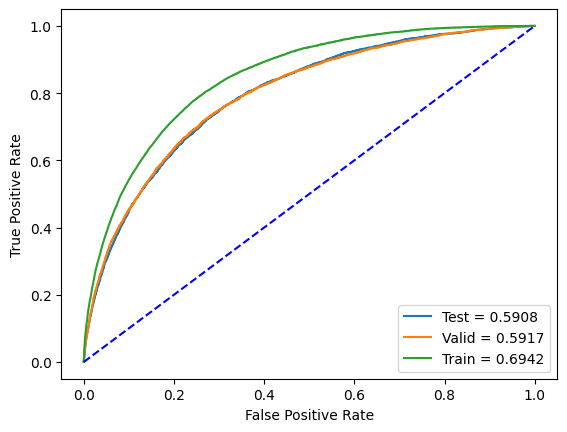

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver_2.csv', index = False)

# Tune - ver3

In [ ]:
lst_ginis = []
lst_params = []
lst_fl = [0]
for i in range(10):
    lst_fl.append(i/10)

for value in range(50, 200, 10):
    fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

    fit = lgb.Dataset(
        train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
        init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
    )

    val = lgb.Dataset(
        valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
        init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
        reference=fit
    )

    params = {
           'objective': 'binary',
      'boost_from_average': True,
      'max_bin': i, 
      'max_depth': 12, 
      'learning_rate': 0.034348802349598966,
      'num_leaves': 16, 
      'lambda_l2': 4.839736625515825e-05, 
      'lambda_l1': 0.011784631017575379, 
      'min_gain_to_split': 6.7019518271194505e-06, 
      'min_data_in_leaf': 3124, 
      'feature_fraction': 0.2510984803589828, 
      'min_sum_hessian_in_leaf': 3.8925793495459575
    }

    model_ver3_tune = lgb.train(
        params= params,
        train_set=fit,
        num_boost_round=10000,
        valid_sets=(fit, val),
        valid_names=('fit', 'val'),
        early_stopping_rounds=50,
        verbose_eval=100,
        fobj=fl.lgb_obj,
        feval=fl.lgb_eval
    )
    pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver3_tune.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
    gini_ = 2 * metrics.roc_auc_score(valid['TARGET'], pred_valid) - 1
    
    lst_params.append(value)
    lst_ginis.append(gini_)
    del model_ver3_tune, fl, fit, val
    gc.collect()

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.526952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4336
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 505
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00901311	val's focal_loss: 0.00902747
[200]	fit's focal_loss: 0.00873212	val's focal_loss: 0.00882221
[300]	fit's focal_loss: 0.00858945	val's focal_loss: 0.00874634
[400]	fit's focal_loss: 0.00848747	val's focal_loss: 0.00870811
[500]	fit's focal_loss: 0.00840446	val's focal_loss: 0.00868736
[600]	fit's focal_loss: 0.00833033	val's focal_loss: 0.00867518
[700

In [ ]:
dat = pd.DataFrame({'GINI': lst_ginis, 'PARAMS': lst_params})
dat = dat.sort_values(by = ['PARAMS'])
dat

# Evaluation - ver 3

In [ ]:
fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 300, 
     'max_depth': 12, 
     'learning_rate': 0.034348802349598966,
     'num_leaves': 16, 
     'lambda_l2': 4.839736625515825e-05, 
     'lambda_l1': 0.011784631017575379, 
     'min_gain_to_split': 6.7019518271194505e-06, 
     'min_data_in_leaf': 3124, 
     'feature_fraction': 0.2510984803589828, 
     'min_sum_hessian_in_leaf': 3.8925793495459575
}
    # params={'learning_rate': 0.018437, 
    #       'num_leaves': 58,
    #       'max_bin': 300,
    #       'colsample_bytree':0.613, 
    #       'subsample':0.708, 
    #       'max_depth':7, 
    #       'reg_alpha':3.564, 
    #       'reg_lambda':4.930, 
    #       'min_split_gain':0.143, 
    #       'min_child_weight':6, 'verbose': -1},

model_ver3 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

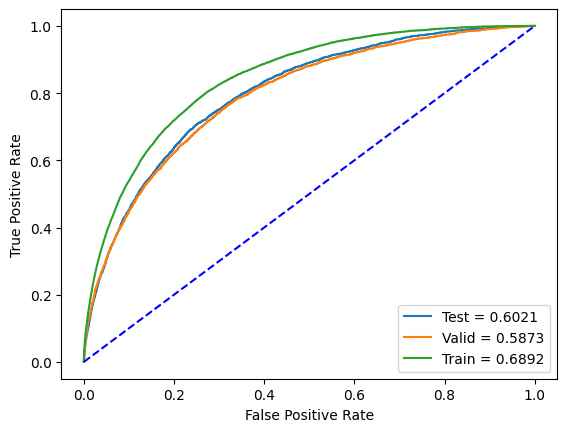

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver3.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver3.csv', index = False)

# Evaluation - ver4

In [ ]:
fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 300, 
     'max_depth': 12, 
     'learning_rate': 0.034348802349598966,
     'num_leaves': 16, 
     'lambda_l2': 4.839736625515825e-05, 
     'lambda_l1': 0.011784631017575379, 
     'min_gain_to_split': 6.7019518271194505e-06, 
     'min_data_in_leaf': 3554, 
     'feature_fraction': 0.2510984803589828, 
     'min_sum_hessian_in_leaf': 3.8925793495459575
}
    # params={'learning_rate': 0.018437, 
    #       'num_leaves': 58,
    #       'max_bin': 300,
    #       'colsample_bytree':0.613, 
    #       'subsample':0.708, 
    #       'max_depth':7, 
    #       'reg_alpha':3.564, 
    #       'reg_lambda':4.930, 
    #       'min_split_gain':0.143, 
    #       'min_child_weight':6, 'verbose': -1},

model_ver4 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.419542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108924
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 503
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00893122	val's focal_loss: 0.00904663
[200]	fit's focal_loss: 0.00862667	val's focal_loss: 0.00881476
[300]	fit's focal_loss: 0.00847199	val's focal_loss: 0.00873607
[400]	fit's focal_loss: 0.00835977	val's focal_loss: 0.00869864
[500]	fit's focal_loss: 0.00826339	val's focal_loss: 0.00867617
[600]	fit's focal_loss: 0.00818049	val's focal_loss: 0.00866372
[7

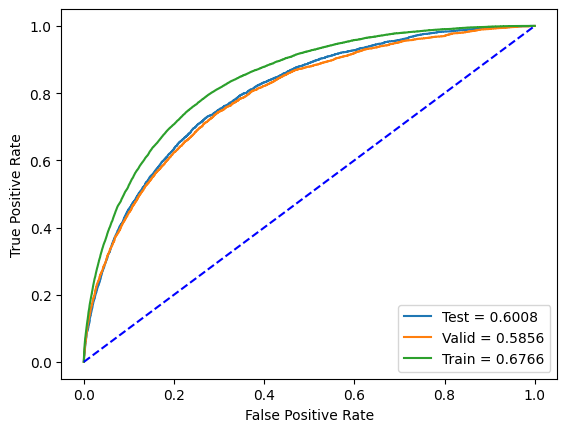

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver4.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver4.csv', index = False)

# Evaluation - ver 5

In [ ]:
fl = FocalLoss(alpha=0.4753777729267357, gamma=0.08434846735207548)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 300, 
    'max_depth': 19, 
    'learning_rate': 0.02095224305573461, 
    'num_leaves': 32, 
    'lambda_l2': 0.0016385259765585955, 
    'lambda_l1': 3.0410153932868966e-05, 
    'min_gain_to_split': 2.8206280707571563e-07, 
    'min_data_in_leaf': 3578, 
    'feature_fraction': 0.16498459345958208, 
    'min_sum_hessian_in_leaf': 0.2621989525004435}

model_ver5 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=100,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.538571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108926
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 503
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	fit's focal_loss: 0.112625	val's focal_loss: 0.114209
[200]	fit's focal_loss: 0.107895	val's focal_loss: 0.110813
[300]	fit's focal_loss: 0.10551	val's focal_loss: 0.109556
[400]	fit's focal_loss: 0.103794	val's focal_loss: 0.108908
[500]	fit's focal_loss: 0.102348	val's focal_loss: 0.10854
[600]	fit's focal_loss: 0.101071	val's focal_loss: 0.108295
[700]	fit's focal_loss: 0.099902	val's focal_loss: 0.108116
[LightGBM] [Warning] No further splits wit

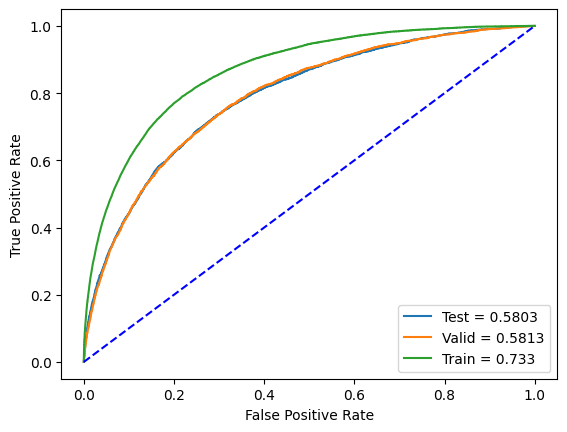

In [ ]:
pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred_kaggle = special.expit(fl.init_score(train['TARGET']) + model_ver5.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred_kaggle
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_focallloss_ver5.csv', index = False)

# Optuna 2

In [ ]:
def objective(trial):
    params_lgb = {
        "objective": "binary",
        "boost_from_average": True,
        "verbose": -1,
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int('max_bin', 250, 350),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 1e-3, 1),
        "subsample": trial.suggest_loguniform("subsample", 1e-3, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1, 5),
        "reg_lambda": trial.suggest_int("reg_lambda", 1, 5),
        'min_split_gain' : trial.suggest_loguniform('min_split_gain', 1e-3, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 10)
    }
    params_focal = {'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
                   'gamma': trial.suggest_loguniform('gamma', 1e-3, 5)}
    
    fl = FocalLoss(alpha=params_focal['alpha'], gamma=params_focal['gamma'])

    fit = lgb.Dataset(
        train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
        init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
    )

    val = lgb.Dataset(
        valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
        init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
        reference=fit
    )
    
    model_tune = lgb.train(params = params_lgb, train_set = fit, num_boost_round=1000,
                           valid_sets=(fit, val), valid_names = ('fit', 'val'),
                           early_stopping_rounds=50, verbose_eval = 100, 
                           fobj=fl.lgb_obj, feval=fl.lgb_eval)
    
    pred_valid = special.expit(fl.init_score(train['TARGET']) + model_tune.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
    gini_ = 2 * metrics.roc_auc_score(valid['TARGET'], pred_valid) - 1
    print('GINI ', gini_)
    del model_tune, fit, val
    gc.collect()
    return gini_

In [ ]:
study_tuner1 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                            direction="maximize", sampler = TPESampler())
study_tuner1.optimize(objective, n_trials=100)
print(study_tuner1.best_trial)

[I 2023-05-20 17:44:32,846] A new study created in memory with name: no-name-f7cf4d9d-df64-4214-b4ac-97300a44379e


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0667925	val's focal_loss: 0.0668616


[I 2023-05-20 17:44:56,069] Trial 0 finished with value: 0.0 and parameters: {'max_bin': 313, 'max_depth': 8, 'learning_rate': 0.01506474480061807, 'num_leaves': 48, 'colsample_bytree': 0.010139456272118349, 'subsample': 0.08096267394235143, 'reg_alpha': 2.449356504747772, 'reg_lambda': 2, 'min_split_gain': 0.37614189063365433, 'min_child_weight': 7, 'alpha': 0.0038479798271900444, 'gamma': 0.06377370630481323}. Best is trial 0 with value: 0.0.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0294865	val's focal_loss: 0.0302455
[200]	fit's focal_loss: 0.0291982	val's focal_loss: 0.0301617
Early stopping, best iteration is:
[161]	fit's focal_loss: 0.0292016	val's focal_loss: 0.0301616


[I 2023-05-20 17:46:37,478] Trial 1 finished with value: 0.5750804387170707 and parameters: {'max_bin': 266, 'max_depth': 13, 'learning_rate': 0.1433229076867342, 'num_leaves': 41, 'colsample_bytree': 0.2524849658809079, 'subsample': 0.04664096056667409, 'reg_alpha': 3.939335296245059, 'reg_lambda': 5, 'min_split_gain': 0.08654869653116706, 'min_child_weight': 5, 'alpha': 0.07223145811795008, 'gamma': 0.04254358420253072}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.5750804387170707
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00355188	val's focal_loss: 0.00352314
[200]	fit's focal_loss: 0.00347465	val's focal_loss: 0.00346303
[300]	fit's focal_loss: 0.00345185	val's focal_loss: 0.00344939
[400]	fit's focal_loss: 0.00344268	val's focal_loss: 0.00344423
Early stopping, best iteration is:
[395]	fit's focal_loss: 0.00344268	val's focal_loss: 0.00344423


[I 2023-05-20 17:49:54,796] Trial 2 finished with value: 0.5655400029274835 and parameters: {'max_bin': 290, 'max_depth': 6, 'learning_rate': 0.05906522647085999, 'num_leaves': 86, 'colsample_bytree': 0.2987531988235597, 'subsample': 0.0020126012213079383, 'reg_alpha': 1.8213659642846187, 'reg_lambda': 4, 'min_split_gain': 0.0014763171687956747, 'min_child_weight': 6, 'alpha': 0.010562973377524376, 'gamma': 0.9357855394580408}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.5655400029274835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0790953	val's focal_loss: 0.0791312


[I 2023-05-20 17:50:15,839] Trial 3 finished with value: 0.0 and parameters: {'max_bin': 297, 'max_depth': 8, 'learning_rate': 0.05268568248133181, 'num_leaves': 41, 'colsample_bytree': 0.0034675612205075776, 'subsample': 0.01214155494119624, 'reg_alpha': 1.028107433642566, 'reg_lambda': 3, 'min_split_gain': 0.13696653588714716, 'min_child_weight': 9, 'alpha': 0.019692567185870542, 'gamma': 0.006116773958335254}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0149841	val's focal_loss: 0.0149986


[I 2023-05-20 17:50:41,873] Trial 4 finished with value: 0.0 and parameters: {'max_bin': 350, 'max_depth': 6, 'learning_rate': 0.3527323991078711, 'num_leaves': 61, 'colsample_bytree': 0.44656452133995445, 'subsample': 0.5480244602150519, 'reg_alpha': 2.061813757121608, 'reg_lambda': 2, 'min_split_gain': 0.15878029475036723, 'min_child_weight': 8, 'alpha': 0.0012387845256520542, 'gamma': 0.6616878407230716}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0353382	val's focal_loss: 0.0352177
[200]	fit's focal_loss: 0.0234098	val's focal_loss: 0.0232559
[300]	fit's focal_loss: 0.0203218	val's focal_loss: 0.0202029
[400]	fit's focal_loss: 0.0194317	val's focal_loss: 0.0193758
[500]	fit's focal_loss: 0.0190634	val's focal_loss: 0.0190802
[600]	fit's focal_loss: 0.018848	val's focal_loss: 0.0189392
[700]	fit's focal_loss: 0.0186963	val's focal_loss: 0.0188579
[800]	fit's focal_loss: 0.0185771	val's focal_loss: 0.0188061
[900]	fit's focal_loss: 0.0184759	val's focal_loss: 0.0187695
[1000]	fit's focal_loss: 0.0183858	val's focal_loss: 0.0187438
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0183858	val's focal_loss: 0.0187438


[I 2023-05-20 17:58:17,571] Trial 5 finished with value: 0.5702806876227178 and parameters: {'max_bin': 267, 'max_depth': 11, 'learning_rate': 0.011482855202120603, 'num_leaves': 50, 'colsample_bytree': 0.2782878836729307, 'subsample': 0.053732424870475776, 'reg_alpha': 1.7591492116343839, 'reg_lambda': 1, 'min_split_gain': 0.0028094589961385015, 'min_child_weight': 6, 'alpha': 0.03970794628984731, 'gamma': 0.027785862445164164}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.5702806876227178
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00242515	val's focal_loss: 0.00239825
[200]	fit's focal_loss: 0.00237045	val's focal_loss: 0.00234683
[300]	fit's focal_loss: 0.00235486	val's focal_loss: 0.00233265
[400]	fit's focal_loss: 0.00234311	val's focal_loss: 0.00232159
[500]	fit's focal_loss: 0.00233466	val's focal_loss: 0.00231387
[600]	fit's focal_loss: 0.00232649	val's focal_loss: 0.00230654
[700]	fit's focal_loss: 0.0023195	val's focal_loss: 0.00229997
[800]	fit's focal_loss: 0.00231315	val's focal_loss: 0.00229416
[900]	fit's focal_loss: 0.00230754	val's focal_loss: 0.00228908
[1000]	fit's focal_loss: 0.00230166	val's focal_loss: 0.00228362
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00230166	val's focal_loss: 0.00228362


[I 2023-05-20 17:59:53,307] Trial 6 finished with value: 0.47738399847126933 and parameters: {'max_bin': 283, 'max_depth': 10, 'learning_rate': 0.01370418513442882, 'num_leaves': 94, 'colsample_bytree': 0.004422313163500204, 'subsample': 0.194642447211399, 'reg_alpha': 3.6340514638034733, 'reg_lambda': 2, 'min_split_gain': 0.0012978910186105576, 'min_child_weight': 5, 'alpha': 0.018126606873452716, 'gamma': 2.8033823321411737}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.47738399847126933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0763707	val's focal_loss: 0.0764568


[I 2023-05-20 18:00:26,356] Trial 7 finished with value: 0.0 and parameters: {'max_bin': 254, 'max_depth': 11, 'learning_rate': 0.04141802443631974, 'num_leaves': 63, 'colsample_bytree': 0.2890956220236556, 'subsample': 0.025125394207342708, 'reg_alpha': 3.259339029256078, 'reg_lambda': 1, 'min_split_gain': 0.009593030521935272, 'min_child_weight': 6, 'alpha': 0.0020128184569077226, 'gamma': 0.0086094899926461}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.630285	val's focal_loss: 0.617811


[I 2023-05-20 18:00:46,689] Trial 8 finished with value: 0.0 and parameters: {'max_bin': 342, 'max_depth': 5, 'learning_rate': 0.3241091921862576, 'num_leaves': 80, 'colsample_bytree': 0.007296887385279146, 'subsample': 0.002466548802277004, 'reg_alpha': 1.6207977163740843, 'reg_lambda': 2, 'min_split_gain': 0.012317855902121803, 'min_child_weight': 8, 'alpha': 4.364720756265227, 'gamma': 0.004045893292664791}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.130332	val's focal_loss: 0.129975
[200]	fit's focal_loss: 0.124315	val's focal_loss: 0.124994
[300]	fit's focal_loss: 0.121658	val's focal_loss: 0.123127
[400]	fit's focal_loss: 0.119394	val's focal_loss: 0.121648
[500]	fit's focal_loss: 0.118059	val's focal_loss: 0.121004
[600]	fit's focal_loss: 0.116951	val's focal_loss: 0.120666
[700]	fit's focal_loss: 0.115764	val's focal_loss: 0.120121
[800]	fit's focal_loss: 0.114595	val's focal_loss: 0.119524
[900]	fit's focal_loss: 0.11376	val's focal_loss: 0.119364
[1000]	fit's focal_loss: 0.112983	val's focal_loss: 0.119206
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.112983	val's focal_loss: 0.119206


[I 2023-05-20 18:02:27,669] Trial 9 finished with value: 0.5284441479199913 and parameters: {'max_bin': 341, 'max_depth': 6, 'learning_rate': 0.09040241841877546, 'num_leaves': 42, 'colsample_bytree': 0.0017650507119876032, 'subsample': 0.0038303586302439003, 'reg_alpha': 1.1428485906927779, 'reg_lambda': 4, 'min_split_gain': 0.005620463840303948, 'min_child_weight': 9, 'alpha': 0.47325981399632916, 'gamma': 0.001857013373758778}. Best is trial 1 with value: 0.5750804387170707.


GINI  0.5284441479199913
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0472382	val's focal_loss: 0.0487187
[200]	fit's focal_loss: 0.0454715	val's focal_loss: 0.0485132
Early stopping, best iteration is:
[241]	fit's focal_loss: 0.0449143	val's focal_loss: 0.0484819


[I 2023-05-20 18:04:04,761] Trial 10 finished with value: 0.5771417407754216 and parameters: {'max_bin': 320, 'max_depth': 14, 'learning_rate': 0.16387093635837527, 'num_leaves': 35, 'colsample_bytree': 0.06263594133829661, 'subsample': 0.01087591877546107, 'reg_alpha': 4.940177250691911, 'reg_lambda': 5, 'min_split_gain': 0.038424638684727626, 'min_child_weight': 5, 'alpha': 0.15173170549433843, 'gamma': 0.1822250617863247}. Best is trial 10 with value: 0.5771417407754216.


GINI  0.5771417407754216
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0442233	val's focal_loss: 0.0452406
[200]	fit's focal_loss: 0.0429426	val's focal_loss: 0.0449949
[300]	fit's focal_loss: 0.0423912	val's focal_loss: 0.0449616
[400]	fit's focal_loss: 0.0422725	val's focal_loss: 0.04495
Early stopping, best iteration is:
[384]	fit's focal_loss: 0.0422797	val's focal_loss: 0.0449489


[I 2023-05-20 18:06:15,795] Trial 11 finished with value: 0.5801847236047277 and parameters: {'max_bin': 317, 'max_depth': 15, 'learning_rate': 0.15757220939620759, 'num_leaves': 30, 'colsample_bytree': 0.06241901269760684, 'subsample': 0.010437307619797796, 'reg_alpha': 4.737312496063256, 'reg_lambda': 5, 'min_split_gain': 0.06569798409905014, 'min_child_weight': 5, 'alpha': 0.13144785903648168, 'gamma': 0.13447374042215995}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5801847236047277
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0598272	val's focal_loss: 0.0620795
[200]	fit's focal_loss: 0.0572889	val's focal_loss: 0.0618333
Early stopping, best iteration is:
[239]	fit's focal_loss: 0.0564622	val's focal_loss: 0.0618083


[I 2023-05-20 18:07:54,115] Trial 12 finished with value: 0.5759297268844832 and parameters: {'max_bin': 318, 'max_depth': 15, 'learning_rate': 0.16710993560134307, 'num_leaves': 30, 'colsample_bytree': 0.05466915243738573, 'subsample': 0.009603982959645305, 'reg_alpha': 4.9281808302643295, 'reg_lambda': 5, 'min_split_gain': 0.033555575697808496, 'min_child_weight': 5, 'alpha': 0.22550028504287178, 'gamma': 0.24885298290077493}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5759297268844832
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0720716	val's focal_loss: 0.0767826
Early stopping, best iteration is:
[142]	fit's focal_loss: 0.0701134	val's focal_loss: 0.0766945


[I 2023-05-20 18:09:03,557] Trial 13 finished with value: 0.5737113483505478 and parameters: {'max_bin': 321, 'max_depth': 15, 'learning_rate': 0.20172324047652718, 'num_leaves': 34, 'colsample_bytree': 0.05676948332743281, 'subsample': 0.007436870032915336, 'reg_alpha': 4.265489836552758, 'reg_lambda': 4, 'min_split_gain': 0.03318854785325792, 'min_child_weight': 10, 'alpha': 0.2891068999764465, 'gamma': 0.18281277519954323}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5737113483505478
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0386522	val's focal_loss: 0.0388041
[200]	fit's focal_loss: 0.0384421	val's focal_loss: 0.0386558
[300]	fit's focal_loss: 0.0383536	val's focal_loss: 0.0385809
[400]	fit's focal_loss: 0.0383336	val's focal_loss: 0.0385617
[500]	fit's focal_loss: 0.0383196	val's focal_loss: 0.0385478
Early stopping, best iteration is:
[458]	fit's focal_loss: 0.0383196	val's focal_loss: 0.0385478


[I 2023-05-20 18:11:11,265] Trial 14 finished with value: 0.5629568118692458 and parameters: {'max_bin': 326, 'max_depth': 13, 'learning_rate': 0.43787847037397476, 'num_leaves': 53, 'colsample_bytree': 0.0235828763608465, 'subsample': 0.0012319786982594037, 'reg_alpha': 4.854026332106985, 'reg_lambda': 5, 'min_split_gain': 0.49594978969182724, 'min_child_weight': 7, 'alpha': 0.10513415287498207, 'gamma': 0.11635910026330953}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5629568118692458
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0724365	val's focal_loss: 0.084082
[200]	fit's focal_loss: 0.0629693	val's focal_loss: 0.0841847
Early stopping, best iteration is:
[153]	fit's focal_loss: 0.0669428	val's focal_loss: 0.0838732


[I 2023-05-20 18:12:36,603] Trial 15 finished with value: 0.5668192714263016 and parameters: {'max_bin': 310, 'max_depth': 13, 'learning_rate': 0.10420984532830276, 'num_leaves': 75, 'colsample_bytree': 0.09788800453652846, 'subsample': 0.018429770640955488, 'reg_alpha': 3.1040810296135226, 'reg_lambda': 4, 'min_split_gain': 0.057367951584329877, 'min_child_weight': 5, 'alpha': 0.9156035493191143, 'gamma': 0.02249794459962533}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5668192714263016
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0343778	val's focal_loss: 0.0343401
[200]	fit's focal_loss: 0.0341668	val's focal_loss: 0.0341674
[300]	fit's focal_loss: 0.0340947	val's focal_loss: 0.0341147
[400]	fit's focal_loss: 0.0340777	val's focal_loss: 0.0340986
[500]	fit's focal_loss: 0.0340692	val's focal_loss: 0.0340935
Early stopping, best iteration is:
[509]	fit's focal_loss: 0.034068	val's focal_loss: 0.0340919


[I 2023-05-20 18:14:52,939] Trial 16 finished with value: 0.562500229796514 and parameters: {'max_bin': 331, 'max_depth': 14, 'learning_rate': 0.2338950347913643, 'num_leaves': 30, 'colsample_bytree': 0.021737444641467988, 'subsample': 0.005206697302649003, 'reg_alpha': 4.981507391523981, 'reg_lambda': 5, 'min_split_gain': 0.9667144584334786, 'min_child_weight': 6, 'alpha': 0.1156489120738512, 'gamma': 0.40519876613399286}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.562500229796514
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0196823	val's focal_loss: 0.0200776
[200]	fit's focal_loss: 0.0191169	val's focal_loss: 0.019986
Early stopping, best iteration is:
[239]	fit's focal_loss: 0.0190358	val's focal_loss: 0.0199738


[I 2023-05-20 18:16:35,219] Trial 17 finished with value: 0.57920616309779 and parameters: {'max_bin': 308, 'max_depth': 15, 'learning_rate': 0.11003270763262632, 'num_leaves': 55, 'colsample_bytree': 0.8035228314402495, 'subsample': 0.01525646519138324, 'reg_alpha': 2.909921186279909, 'reg_lambda': 3, 'min_split_gain': 0.013773074297674756, 'min_child_weight': 7, 'alpha': 0.04608285493647917, 'gamma': 0.09915464503038168}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.57920616309779
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0186017	val's focal_loss: 0.0188329
[200]	fit's focal_loss: 0.0180583	val's focal_loss: 0.0187091
[300]	fit's focal_loss: 0.017833	val's focal_loss: 0.0186883
Early stopping, best iteration is:
[286]	fit's focal_loss: 0.0178355	val's focal_loss: 0.0186879


[I 2023-05-20 18:18:51,894] Trial 18 finished with value: 0.5784296347174487 and parameters: {'max_bin': 302, 'max_depth': 12, 'learning_rate': 0.09094993919224469, 'num_leaves': 70, 'colsample_bytree': 0.988173507158689, 'subsample': 0.022822622523550457, 'reg_alpha': 2.7525021216010526, 'reg_lambda': 3, 'min_split_gain': 0.011832095594627813, 'min_child_weight': 7, 'alpha': 0.04216855336873628, 'gamma': 0.09122182254361261}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5784296347174487
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0737837	val's focal_loss: 0.0738519


[I 2023-05-20 18:19:21,867] Trial 19 finished with value: 0.0 and parameters: {'max_bin': 282, 'max_depth': 15, 'learning_rate': 0.25217221229239417, 'num_leaves': 56, 'colsample_bytree': 0.13259201672280738, 'subsample': 0.005992260874565352, 'reg_alpha': 3.4517077750753775, 'reg_lambda': 3, 'min_split_gain': 0.0178758308782284, 'min_child_weight': 8, 'alpha': 0.006903420591739597, 'gamma': 0.025882830678838502}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0206054	val's focal_loss: 0.0210281
[200]	fit's focal_loss: 0.0201245	val's focal_loss: 0.0209413
Early stopping, best iteration is:
[201]	fit's focal_loss: 0.020124	val's focal_loss: 0.0209412


[I 2023-05-20 18:20:55,249] Trial 20 finished with value: 0.5779019622982673 and parameters: {'max_bin': 302, 'max_depth': 10, 'learning_rate': 0.1279839495243269, 'num_leaves': 70, 'colsample_bytree': 0.9167804020492932, 'subsample': 0.015194968089567084, 'reg_alpha': 2.9825801365544247, 'reg_lambda': 3, 'min_split_gain': 0.02248235810877839, 'min_child_weight': 10, 'alpha': 0.04805735329904418, 'gamma': 0.08373809205383291}. Best is trial 11 with value: 0.5801847236047277.


GINI  0.5779019622982673
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0190715	val's focal_loss: 0.0193683
[200]	fit's focal_loss: 0.0184447	val's focal_loss: 0.019239
[300]	fit's focal_loss: 0.0180533	val's focal_loss: 0.0192179
Early stopping, best iteration is:
[308]	fit's focal_loss: 0.0180281	val's focal_loss: 0.0192155


[I 2023-05-20 18:23:31,087] Trial 21 finished with value: 0.5802479636053994 and parameters: {'max_bin': 305, 'max_depth': 12, 'learning_rate': 0.09008722582584916, 'num_leaves': 70, 'colsample_bytree': 0.9560389034452258, 'subsample': 0.0301790851621473, 'reg_alpha': 2.6972649781753355, 'reg_lambda': 3, 'min_split_gain': 0.006388845306173709, 'min_child_weight': 7, 'alpha': 0.044937367654490065, 'gamma': 0.12273738501498434}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.5802479636053994
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0109086	val's focal_loss: 0.0109253
[200]	fit's focal_loss: 0.0106865	val's focal_loss: 0.01083
[300]	fit's focal_loss: 0.0105857	val's focal_loss: 0.0108017
Early stopping, best iteration is:
[314]	fit's focal_loss: 0.0105828	val's focal_loss: 0.0108004


[I 2023-05-20 18:25:22,724] Trial 22 finished with value: 0.573749338061825 and parameters: {'max_bin': 307, 'max_depth': 14, 'learning_rate': 0.0770328115488822, 'num_leaves': 86, 'colsample_bytree': 0.6047986233260628, 'subsample': 0.03530776870465324, 'reg_alpha': 2.737702878374896, 'reg_lambda': 3, 'min_split_gain': 0.0039413586150573235, 'min_child_weight': 7, 'alpha': 0.02760077377053477, 'gamma': 0.36608991786648937}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.573749338061825
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0269186	val's focal_loss: 0.0278065
[200]	fit's focal_loss: 0.0258772	val's focal_loss: 0.0277192
Early stopping, best iteration is:
[206]	fit's focal_loss: 0.0258354	val's focal_loss: 0.0277159


[I 2023-05-20 18:27:01,765] Trial 23 finished with value: 0.57935448494726 and parameters: {'max_bin': 294, 'max_depth': 12, 'learning_rate': 0.12110338607693519, 'num_leaves': 100, 'colsample_bytree': 0.5966321305251766, 'subsample': 0.017995264262712213, 'reg_alpha': 3.988420244594758, 'reg_lambda': 4, 'min_split_gain': 0.00776507354546721, 'min_child_weight': 9, 'alpha': 0.07086337849083593, 'gamma': 0.1312269421861978}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.57935448494726
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0301869	val's focal_loss: 0.0319347
Early stopping, best iteration is:
[143]	fit's focal_loss: 0.0294001	val's focal_loss: 0.0319026


[I 2023-05-20 18:28:20,798] Trial 24 finished with value: 0.5742418528564972 and parameters: {'max_bin': 292, 'max_depth': 12, 'learning_rate': 0.14576764987510932, 'num_leaves': 91, 'colsample_bytree': 0.4659176287158766, 'subsample': 0.03187100543174167, 'reg_alpha': 4.113071661026435, 'reg_lambda': 4, 'min_split_gain': 0.007163972308526978, 'min_child_weight': 9, 'alpha': 0.08721722807374968, 'gamma': 0.17030615367350954}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.5742418528564972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.0712326	val's focal_loss: 0.0712683


[I 2023-05-20 18:28:54,782] Trial 25 finished with value: 0.0 and parameters: {'max_bin': 282, 'max_depth': 9, 'learning_rate': 0.07092364414963825, 'num_leaves': 99, 'colsample_bytree': 0.2151956991851263, 'subsample': 0.07009320621424356, 'reg_alpha': 3.712899854328009, 'reg_lambda': 4, 'min_split_gain': 0.005466249906872876, 'min_child_weight': 9, 'alpha': 0.016656964101564795, 'gamma': 0.047680259648225934}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0177641	val's focal_loss: 0.0183015
[200]	fit's focal_loss: 0.0175597	val's focal_loss: 0.0182584
[300]	fit's focal_loss: 0.0175446	val's focal_loss: 0.0182527
Early stopping, best iteration is:
[266]	fit's focal_loss: 0.0175448	val's focal_loss: 0.0182526


[I 2023-05-20 18:30:51,261] Trial 26 finished with value: 0.5738842149520074 and parameters: {'max_bin': 333, 'max_depth': 12, 'learning_rate': 0.19835894546622354, 'num_leaves': 100, 'colsample_bytree': 0.13318842969251812, 'subsample': 0.007127925871973277, 'reg_alpha': 4.168363970252274, 'reg_lambda': 4, 'min_split_gain': 0.018915943484935853, 'min_child_weight': 10, 'alpha': 0.06773720630517267, 'gamma': 0.7299475598124078}. Best is trial 21 with value: 0.5802479636053994.


GINI  0.5738842149520074
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0583361	val's focal_loss: 0.0642413
[200]	fit's focal_loss: 0.0527532	val's focal_loss: 0.0642489
Early stopping, best iteration is:
[157]	fit's focal_loss: 0.0550244	val's focal_loss: 0.0641483


[I 2023-05-20 18:33:02,725] Trial 27 finished with value: 0.5809014005513728 and parameters: {'max_bin': 292, 'max_depth': 11, 'learning_rate': 0.11191285585520627, 'num_leaves': 81, 'colsample_bytree': 0.6084455289484175, 'subsample': 0.09458130174161039, 'reg_alpha': 3.4997800016129537, 'reg_lambda': 5, 'min_split_gain': 0.002299867717192947, 'min_child_weight': 8, 'alpha': 0.18751149489446622, 'gamma': 0.01464849989821756}. Best is trial 27 with value: 0.5809014005513728.


GINI  0.5809014005513728
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.100901	val's focal_loss: 0.104871
[200]	fit's focal_loss: 0.0951314	val's focal_loss: 0.103116
[300]	fit's focal_loss: 0.0910751	val's focal_loss: 0.102569
[400]	fit's focal_loss: 0.0875641	val's focal_loss: 0.102336
[500]	fit's focal_loss: 0.0843268	val's focal_loss: 0.10225
[600]	fit's focal_loss: 0.0812844	val's focal_loss: 0.102228
Early stopping, best iteration is:
[632]	fit's focal_loss: 0.0803807	val's focal_loss: 0.102198


[I 2023-05-20 18:40:49,431] Trial 28 finished with value: 0.5870042394848347 and parameters: {'max_bin': 272, 'max_depth': 10, 'learning_rate': 0.03367920207396604, 'num_leaves': 78, 'colsample_bytree': 0.4276833691505903, 'subsample': 0.10781371350669815, 'reg_alpha': 3.4068120998415794, 'reg_lambda': 5, 'min_split_gain': 0.002330925838019653, 'min_child_weight': 8, 'alpha': 0.38779878570874593, 'gamma': 0.02019357833342426}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5870042394848347
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.1192	val's focal_loss: 0.126262
[200]	fit's focal_loss: 0.111783	val's focal_loss: 0.124219
[300]	fit's focal_loss: 0.10639	val's focal_loss: 0.123614
[400]	fit's focal_loss: 0.101805	val's focal_loss: 0.123371
[500]	fit's focal_loss: 0.0975696	val's focal_loss: 0.123276
[600]	fit's focal_loss: 0.0936442	val's focal_loss: 0.123246
Early stopping, best iteration is:
[557]	fit's focal_loss: 0.0953014	val's focal_loss: 0.123213


[I 2023-05-20 18:45:29,671] Trial 29 finished with value: 0.5845216719726058 and parameters: {'max_bin': 272, 'max_depth': 9, 'learning_rate': 0.03214761620957478, 'num_leaves': 79, 'colsample_bytree': 0.46833001254899437, 'subsample': 0.10885572189101418, 'reg_alpha': 2.485209921912925, 'reg_lambda': 5, 'min_split_gain': 0.0023471330451121197, 'min_child_weight': 8, 'alpha': 0.6488016651727422, 'gamma': 0.013352883776170716}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5845216719726058
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.095426	val's focal_loss: 0.101842
[200]	fit's focal_loss: 0.0889226	val's focal_loss: 0.0995775
[300]	fit's focal_loss: 0.0843988	val's focal_loss: 0.0989254
[400]	fit's focal_loss: 0.0805958	val's focal_loss: 0.0987164
[500]	fit's focal_loss: 0.0772816	val's focal_loss: 0.0987466
Early stopping, best iteration is:
[452]	fit's focal_loss: 0.0787976	val's focal_loss: 0.0986859


[I 2023-05-20 18:51:45,491] Trial 30 finished with value: 0.5825569689159102 and parameters: {'max_bin': 270, 'max_depth': 9, 'learning_rate': 0.0277259036668795, 'num_leaves': 79, 'colsample_bytree': 0.517224739915478, 'subsample': 0.11768772966669379, 'reg_alpha': 2.2798007455586027, 'reg_lambda': 5, 'min_split_gain': 0.0022658282692994652, 'min_child_weight': 8, 'alpha': 0.8724029185179827, 'gamma': 0.011596414363577433}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5825569689159102
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.120954	val's focal_loss: 0.126414
[200]	fit's focal_loss: 0.114194	val's focal_loss: 0.124085
[300]	fit's focal_loss: 0.109725	val's focal_loss: 0.123314
[400]	fit's focal_loss: 0.106047	val's focal_loss: 0.122921
[500]	fit's focal_loss: 0.102677	val's focal_loss: 0.12271
[600]	fit's focal_loss: 0.0995023	val's focal_loss: 0.122647
[700]	fit's focal_loss: 0.0966238	val's focal_loss: 0.122634
[800]	fit's focal_loss: 0.0938861	val's focal_loss: 0.122608
Early stopping, best iteration is:
[813]	fit's focal_loss: 0.0935324	val's focal_loss: 0.12258


[I 2023-05-20 18:57:42,339] Trial 31 finished with value: 0.5845197541033209 and parameters: {'max_bin': 269, 'max_depth': 8, 'learning_rate': 0.02656752287292553, 'num_leaves': 79, 'colsample_bytree': 0.4535284505703935, 'subsample': 0.10801940599206983, 'reg_alpha': 2.3583816534517013, 'reg_lambda': 5, 'min_split_gain': 0.002192925690651369, 'min_child_weight': 8, 'alpha': 0.6065721113848123, 'gamma': 0.013286768141710753}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5845197541033209
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.116653	val's focal_loss: 0.122949
[200]	fit's focal_loss: 0.109865	val's focal_loss: 0.120597
[300]	fit's focal_loss: 0.105378	val's focal_loss: 0.119795
[400]	fit's focal_loss: 0.101573	val's focal_loss: 0.119453
[500]	fit's focal_loss: 0.0982002	val's focal_loss: 0.1193
[600]	fit's focal_loss: 0.0949016	val's focal_loss: 0.119289
Early stopping, best iteration is:
[566]	fit's focal_loss: 0.0960524	val's focal_loss: 0.119251


[I 2023-05-20 19:01:56,045] Trial 32 finished with value: 0.5828285710055328 and parameters: {'max_bin': 268, 'max_depth': 8, 'learning_rate': 0.026935253148256365, 'num_leaves': 77, 'colsample_bytree': 0.4320052911547248, 'subsample': 0.17236221618807956, 'reg_alpha': 2.412741813240344, 'reg_lambda': 5, 'min_split_gain': 0.001119343242904768, 'min_child_weight': 8, 'alpha': 0.7528173018234703, 'gamma': 0.012172800319822074}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5828285710055328
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.114526	val's focal_loss: 0.117722
[200]	fit's focal_loss: 0.108687	val's focal_loss: 0.115122
[300]	fit's focal_loss: 0.105151	val's focal_loss: 0.114165
[400]	fit's focal_loss: 0.102335	val's focal_loss: 0.113721
[500]	fit's focal_loss: 0.0998391	val's focal_loss: 0.113444
[600]	fit's focal_loss: 0.0975722	val's focal_loss: 0.113259
[700]	fit's focal_loss: 0.0954382	val's focal_loss: 0.113134
[800]	fit's focal_loss: 0.0932173	val's focal_loss: 0.113073
[900]	fit's focal_loss: 0.0912795	val's focal_loss: 0.113051
[1000]	fit's focal_loss: 0.0893789	val's focal_loss: 0.113023
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0893789	val's focal_loss: 0.113023


[I 2023-05-20 19:11:53,926] Trial 33 finished with value: 0.5865174186751378 and parameters: {'max_bin': 258, 'max_depth': 8, 'learning_rate': 0.021847814532040277, 'num_leaves': 75, 'colsample_bytree': 0.38242163586913536, 'subsample': 0.16935605061111322, 'reg_alpha': 2.4586545342267647, 'reg_lambda': 5, 'min_split_gain': 0.0010052068498137396, 'min_child_weight': 8, 'alpha': 0.5002716457212598, 'gamma': 0.04596743862598775}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5865174186751378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.273772	val's focal_loss: 0.269453


[I 2023-05-20 19:12:27,401] Trial 34 finished with value: 0.0 and parameters: {'max_bin': 250, 'max_depth': 7, 'learning_rate': 0.020348617254838733, 'num_leaves': 85, 'colsample_bytree': 0.20585701380826005, 'subsample': 0.25038441302825337, 'reg_alpha': 2.5237697992347803, 'reg_lambda': 5, 'min_split_gain': 0.00168699878458786, 'min_child_weight': 8, 'alpha': 1.5368547962044554, 'gamma': 0.030568375550402736}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0887479	val's focal_loss: 0.0923165
[200]	fit's focal_loss: 0.0836676	val's focal_loss: 0.0908797
[300]	fit's focal_loss: 0.0803101	val's focal_loss: 0.0904988
[400]	fit's focal_loss: 0.0774059	val's focal_loss: 0.0903909
[500]	fit's focal_loss: 0.0746485	val's focal_loss: 0.0903353
Early stopping, best iteration is:
[537]	fit's focal_loss: 0.0736142	val's focal_loss: 0.0903063


[I 2023-05-20 19:16:10,645] Trial 35 finished with value: 0.5833450144491079 and parameters: {'max_bin': 260, 'max_depth': 9, 'learning_rate': 0.03672508821728607, 'num_leaves': 84, 'colsample_bytree': 0.32579276158185266, 'subsample': 0.369932139832855, 'reg_alpha': 2.172115367388182, 'reg_lambda': 5, 'min_split_gain': 0.0010174730617906822, 'min_child_weight': 9, 'alpha': 0.3255597887011374, 'gamma': 0.05032746940476072}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5833450144491079
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.111985	val's focal_loss: 0.113918
[200]	fit's focal_loss: 0.106668	val's focal_loss: 0.110961
[300]	fit's focal_loss: 0.103558	val's focal_loss: 0.109842
[400]	fit's focal_loss: 0.10138	val's focal_loss: 0.109265
[500]	fit's focal_loss: 0.0996386	val's focal_loss: 0.108926
[600]	fit's focal_loss: 0.098163	val's focal_loss: 0.108678
[700]	fit's focal_loss: 0.0967705	val's focal_loss: 0.108507
[800]	fit's focal_loss: 0.0953697	val's focal_loss: 0.108407
[900]	fit's focal_loss: 0.0940351	val's focal_loss: 0.108312
[1000]	fit's focal_loss: 0.0928091	val's focal_loss: 0.108243
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0928091	val's focal_loss: 0.108243


[I 2023-05-20 19:22:01,916] Trial 36 finished with value: 0.5841991718183319 and parameters: {'max_bin': 274, 'max_depth': 7, 'learning_rate': 0.017162428251418622, 'num_leaves': 74, 'colsample_bytree': 0.36578594707085904, 'subsample': 0.13881643788341647, 'reg_alpha': 2.0456834309874927, 'reg_lambda': 5, 'min_split_gain': 0.003711423568266727, 'min_child_weight': 8, 'alpha': 0.45987355488025206, 'gamma': 0.05808515734326155}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5841991718183319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.30182	val's focal_loss: 0.296852


[I 2023-05-20 19:22:37,267] Trial 37 finished with value: 0.0 and parameters: {'max_bin': 259, 'max_depth': 8, 'learning_rate': 0.0526391490880896, 'num_leaves': 67, 'colsample_bytree': 0.29971430121880843, 'subsample': 0.05963410906894806, 'reg_alpha': 2.5021346470470602, 'reg_lambda': 4, 'min_split_gain': 0.0015726483767041538, 'min_child_weight': 9, 'alpha': 1.7608281669151746, 'gamma': 0.018213184014880302}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.0
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.110758	val's focal_loss: 0.113217
[200]	fit's focal_loss: 0.104666	val's focal_loss: 0.110116
[300]	fit's focal_loss: 0.100872	val's focal_loss: 0.109014
[400]	fit's focal_loss: 0.0978708	val's focal_loss: 0.108498
[500]	fit's focal_loss: 0.09524	val's focal_loss: 0.108202
[600]	fit's focal_loss: 0.0928538	val's focal_loss: 0.108024
[700]	fit's focal_loss: 0.0906574	val's focal_loss: 0.107939
[800]	fit's focal_loss: 0.088502	val's focal_loss: 0.107853
Early stopping, best iteration is:
[818]	fit's focal_loss: 0.0881283	val's focal_loss: 0.107843


[I 2023-05-20 19:29:28,937] Trial 38 finished with value: 0.585848022671799 and parameters: {'max_bin': 276, 'max_depth': 10, 'learning_rate': 0.021239446024429048, 'num_leaves': 90, 'colsample_bytree': 0.18943579246994496, 'subsample': 0.09579757121233018, 'reg_alpha': 3.2210995670679585, 'reg_lambda': 5, 'min_split_gain': 0.0016111007305369253, 'min_child_weight': 8, 'alpha': 0.4224352563171506, 'gamma': 0.006719020055802999}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.585848022671799
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.093884	val's focal_loss: 0.0940191
[200]	fit's focal_loss: 0.0874682	val's focal_loss: 0.0884912
[300]	fit's focal_loss: 0.0843466	val's focal_loss: 0.0862573
[400]	fit's focal_loss: 0.0823634	val's focal_loss: 0.0851413
[500]	fit's focal_loss: 0.0808439	val's focal_loss: 0.0844947
[600]	fit's focal_loss: 0.0796097	val's focal_loss: 0.0840957
[700]	fit's focal_loss: 0.0785412	val's focal_loss: 0.083832
[800]	fit's focal_loss: 0.0775846	val's focal_loss: 0.0836453
[900]	fit's focal_loss: 0.0767239	val's focal_loss: 0.0835128
[1000]	fit's focal_loss: 0.0758942	val's focal_loss: 0.0834137
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0758942	val's focal_loss: 0.0834137


[I 2023-05-20 19:37:08,117] Trial 39 finished with value: 0.5789450645720753 and parameters: {'max_bin': 277, 'max_depth': 10, 'learning_rate': 0.010134106070239134, 'num_leaves': 90, 'colsample_bytree': 0.19589988418317314, 'subsample': 0.07341843325338016, 'reg_alpha': 3.2560109332443887, 'reg_lambda': 5, 'min_split_gain': 0.0015091883268667202, 'min_child_weight': 8, 'alpha': 0.2713015213324721, 'gamma': 0.005201953119436643}. Best is trial 28 with value: 0.5870042394848347.


GINI  0.5789450645720753
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.114543	val's focal_loss: 0.116465
[200]	fit's focal_loss: 0.108298	val's focal_loss: 0.112732
[300]	fit's focal_loss: 0.1046	val's focal_loss: 0.111266
[400]	fit's focal_loss: 0.101841	val's focal_loss: 0.110568
[500]	fit's focal_loss: 0.0995625	val's focal_loss: 0.11013
[600]	fit's focal_loss: 0.097538	val's focal_loss: 0.109866
[700]	fit's focal_loss: 0.095621	val's focal_loss: 0.109681
[800]	fit's focal_loss: 0.0938838	val's focal_loss: 0.10953


In [ ]:
# Trial 0 finished with value: 0.5861026620522534 and parameters: {'max_bin': 292, 'max_depth': 9, 'learning_rate': 0.021575851931854757, 'num_leaves': 99, 'colsample_bytree': 0.23787523912822794, 'subsample': 0.6780627571983611, 'reg_alpha': 1.1011831666506209, 'reg_lambda': 5, 'min_split_gain': 0.003815478236354457, 'min_data_in_leaf': 241, 'alpha': 0.1466336127589902, 'gamma': 0.0010728832300945911}. Best is trial 0 with value: 0.5861026620522534.
# GINI  0.5861026620522534

# Trial 22 finished with value: 0.5862594304762945 and parameters: {'max_bin': 333, 'max_depth': 9, 'learning_rate': 0.022703422344747846, 'num_leaves': 61, 'colsample_bytree': 0.3827331119336031, 'subsample': 0.4923469683862471, 'reg_alpha': 2.6555935673288547, 'reg_lambda': 3, 'min_split_gain': 0.07199279179300867, 'min_data_in_leaf': 1985, 'alpha': 0.485349398519168, 'gamma': 0.004249103247895125}. Best is trial 22 with value: 0.5862594304762945.
# GINI  0.5862594304762945

# Trial 26 finished with value: 0.5871419683360775 and parameters: {'max_bin': 341, 'max_depth': 15, 'learning_rate': 0.020360476676599737, 'num_leaves': 64, 'colsample_bytree': 0.15390329821664328, 'subsample': 0.20331450075384144, 'reg_alpha': 2.5678055317901296, 'reg_lambda': 5, 'min_split_gain': 0.06538447791406805, 'min_data_in_leaf': 633, 'alpha': 0.14288588039203828, 'gamma': 0.002281401722878866}. Best is trial 26 with value: 0.5871419683360775.
# GINI  0.5871419683360775

# Trial 11 finished with value: 0.5801847236047277 and parameters: {'max_bin': 317, 'max_depth': 15, 'learning_rate': 0.15757220939620759, 'num_leaves': 30, 'colsample_bytree': 0.06241901269760684, 'subsample': 0.010437307619797796, 'reg_alpha': 4.737312496063256, 'reg_lambda': 5, 'min_split_gain': 0.06569798409905014, 'min_child_weight': 5, 'alpha': 0.13144785903648168, 'gamma': 0.13447374042215995}. Best is trial 11 with value: 0.5801847236047277.
# GINI  0.5801847236047277

#  Trial 21 finished with value: 0.5802479636053994 and parameters: {'max_bin': 305, 'max_depth': 12, 'learning_rate': 0.09008722582584916, 'num_leaves': 70, 'colsample_bytree': 0.9560389034452258, 'subsample': 0.0301790851621473, 'reg_alpha': 2.6972649781753355, 'reg_lambda': 3, 'min_split_gain': 0.006388845306173709, 'min_child_weight': 7, 'alpha': 0.044937367654490065, 'gamma': 0.12273738501498434}. Best is trial 21 with value: 0.5802479636053994.
# GINI  0.5802479636053994

# Trial 27 finished with value: 0.5809014005513728 and parameters: {'max_bin': 292, 'max_depth': 11, 'learning_rate': 0.11191285585520627, 'num_leaves': 81, 'colsample_bytree': 0.6084455289484175, 'subsample': 0.09458130174161039, 'reg_alpha': 3.4997800016129537, 'reg_lambda': 5, 'min_split_gain': 0.002299867717192947, 'min_child_weight': 8, 'alpha': 0.18751149489446622, 'gamma': 0.01464849989821756}. Best is trial 27 with value: 0.5809014005513728.
# GINI  0.5809014005513728

# Trial 28 finished with value: 0.5870042394848347 and parameters: {'max_bin': 272, 'max_depth': 10, 'learning_rate': 0.03367920207396604, 'num_leaves': 78, 'colsample_bytree': 0.4276833691505903, 'subsample': 0.10781371350669815, 'reg_alpha': 3.4068120998415794, 'reg_lambda': 5, 'min_split_gain': 0.002330925838019653, 'min_child_weight': 8, 'alpha': 0.38779878570874593, 'gamma': 0.02019357833342426}. Best is trial 28 with value: 0.5870042394848347.
# GINI  0.5870042394848347

In [ ]:
fl = FocalLoss(alpha=0.45977312728546776, gamma=3.9539952384075874)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 223, 
     'max_depth': 12, 
     'learning_rate': 0.034348802349598966,
     'num_leaves': 16, 
     'lambda_l2': 4.839736625515825e-05, 
     'lambda_l1': 0.011784631017575379, 
     'min_gain_to_split': 6.7019518271194505e-06, 
     'min_data_in_leaf': 3124, 
     'feature_fraction': 0.2510984803589828, 
     'min_sum_hessian_in_leaf': 3.8925793495459575
}

model_ver2 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=10000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)